# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

 **Исследование прогнозирования оттока клиентов в сети отелей «Как в гостях»** 
 
В нашем распоряжении данные о пользователях сети отелей. Имеются данные о количестве постояльцев, их гражданства, типе заказчика, количестве ночей, а также об отменах бронирования. Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Основная задача проекта заключается в разработке системы, которая могут предсказать, что клиент откажется от брони. Это приведет к сокращению убытков компании.

 **Цель исследования**
 
Цель проекта заключается в анализе данных о пользователях сети отелей, а именно:
1. Проанализировать основную информацию о пользователях.
2. Определить целевой признак и обучить модель машинного обучения по целевому признаку "отмена заказа".
3. Проверить модель на тестовой выборке.
4. Описать основные признаки "ненадежного" клиента.

**Ход исследования**

Данные для исследования получены из двух датафреймов. Один датафрейм будет использован для обучения моедли, другой для ее тестирования.О качестве данных ничего не известно, поэтому понадобится их обзор.

Данные будут проверены на ошибки и пропуски. На этапе предобработки будет рассмотрена возможность устранения ошибок, при их наличии. 

Таким образом, исследование будет состоять из следующих этапов:
- обзор данных;
- предобработка данных;
- исследовательский анализ данных;
- вычисление бизнес-метрики получения прибыли без внедрения депозитов;
- разработка ML - модели определения отказа от бронирования;
- определение основных признаков "ненадежного" клиента;
- основные выводы.

### Шаг 1. Откройте файлы с данными

In [1]:
!pip install scikit-learn==1.1.3 
# нужно для корректной работы OneHotEncoder, чтобы одновременно использовать 
#handle_unknown = 'ignore' и drop = 'first'. 

     |████████████████████████████████| 30.8 MB 893 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
! pip install phik

     |████████████████████████████████| 679 kB 956 kB/s eta 0:00:01


In [3]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     \ 17.8 MB 1.4 MB/sss
     |████████████████████████████████| 381 kB 931 kB/s eta 0:00:01
     |████████████████████████████████| 102 kB 20.1 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 460 kB 27.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 62.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 79.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 90.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 80.2 MB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 80.9 MB/s eta 0:00:01
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=357567 sha256=84e158cf82ea77f6f16c279115a4838cdbf4a2349ea273e0dee6cedb3d655d0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-i_3rmrzh/wheels/43/c8/f4/c0ebc32d7f20fe89d0e92d90eaeef5f0c0594a89b6bc16b352
  Created wheel for htmlmin: filename=htmlmin-0.1.1

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import * 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.dummy import DummyClassifier
from scipy.stats import iqr
import warnings
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot

In [5]:
warnings.filterwarnings('ignore') # отключаем предупреждения
pd.set_option('display.max_columns', None) # настроим показ всех колонок

Прочитаем и посмотрим основные параметры тренировочной выборки.

In [6]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
display(df_train.head())
display(df_train.info())
df_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Прочитаем и посмотрим основные параметры тестовой выборки.

In [7]:
df_test = pd.read_csv('/datasets/hotel_test.csv')
display(df_test.head())
display(df_test.info())
df_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Построим гистограммы распределения признаков в тренировочном датасете.

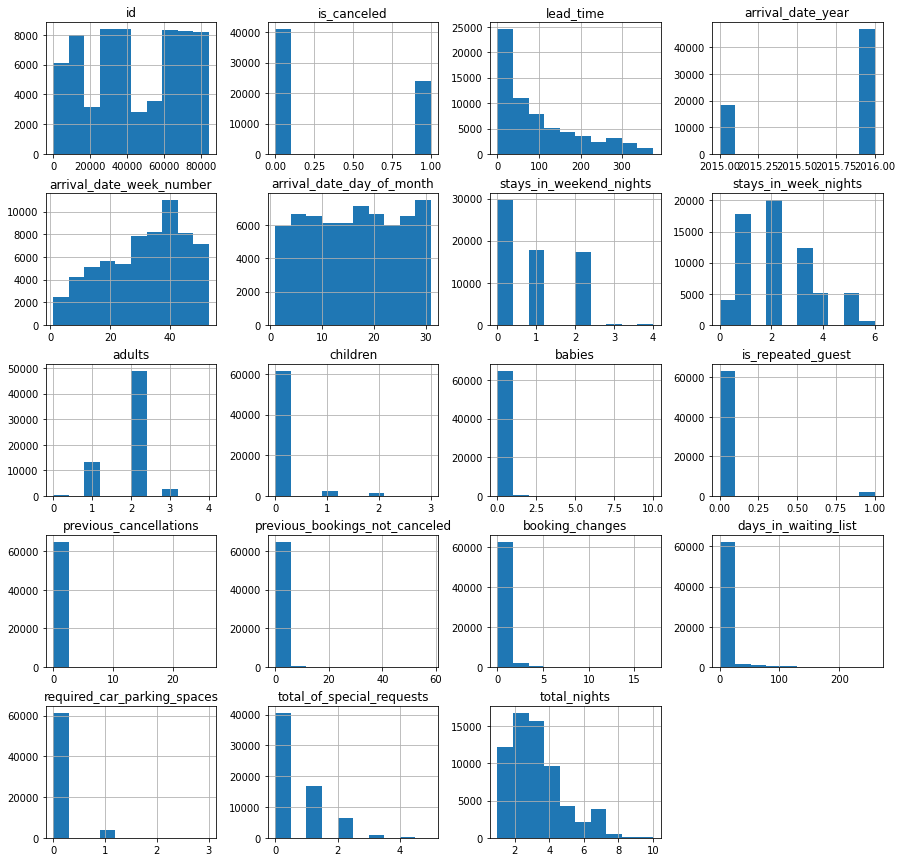

In [8]:
df_train.hist(figsize = (15, 15));

В данном разделе были открыты 2 файла и изучена информация в них. Проведен первичный анализ данных. Определен целевой показатель "отмена заказа" и рассмотрено распределение по всем факторам.

### Шаг 2. Предобработка и исследовательский анализ данных

#### Предобработка данных

Проверим данные на пропуски.

In [9]:
df_train.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [10]:
df_test.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [11]:
pip install sweetviz

     |████████████████████████████████| 15.1 MB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
import sweetviz as sv

my_report = sv.analyze(df_train)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


https://k8s.jupyterhub.praktikum-services.ru/user/user-0-646854226/view/SWEETVIZ_REPORT.html


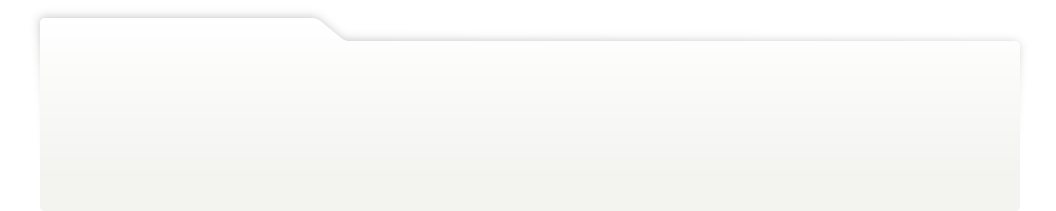
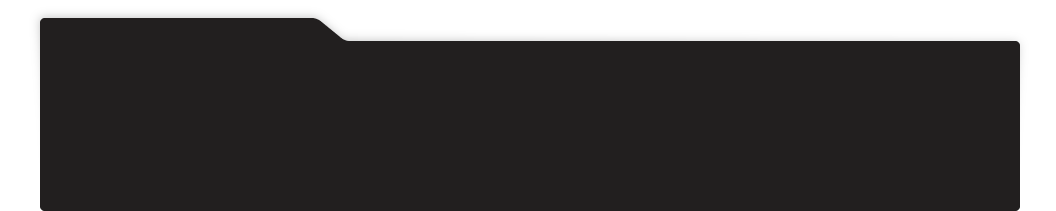
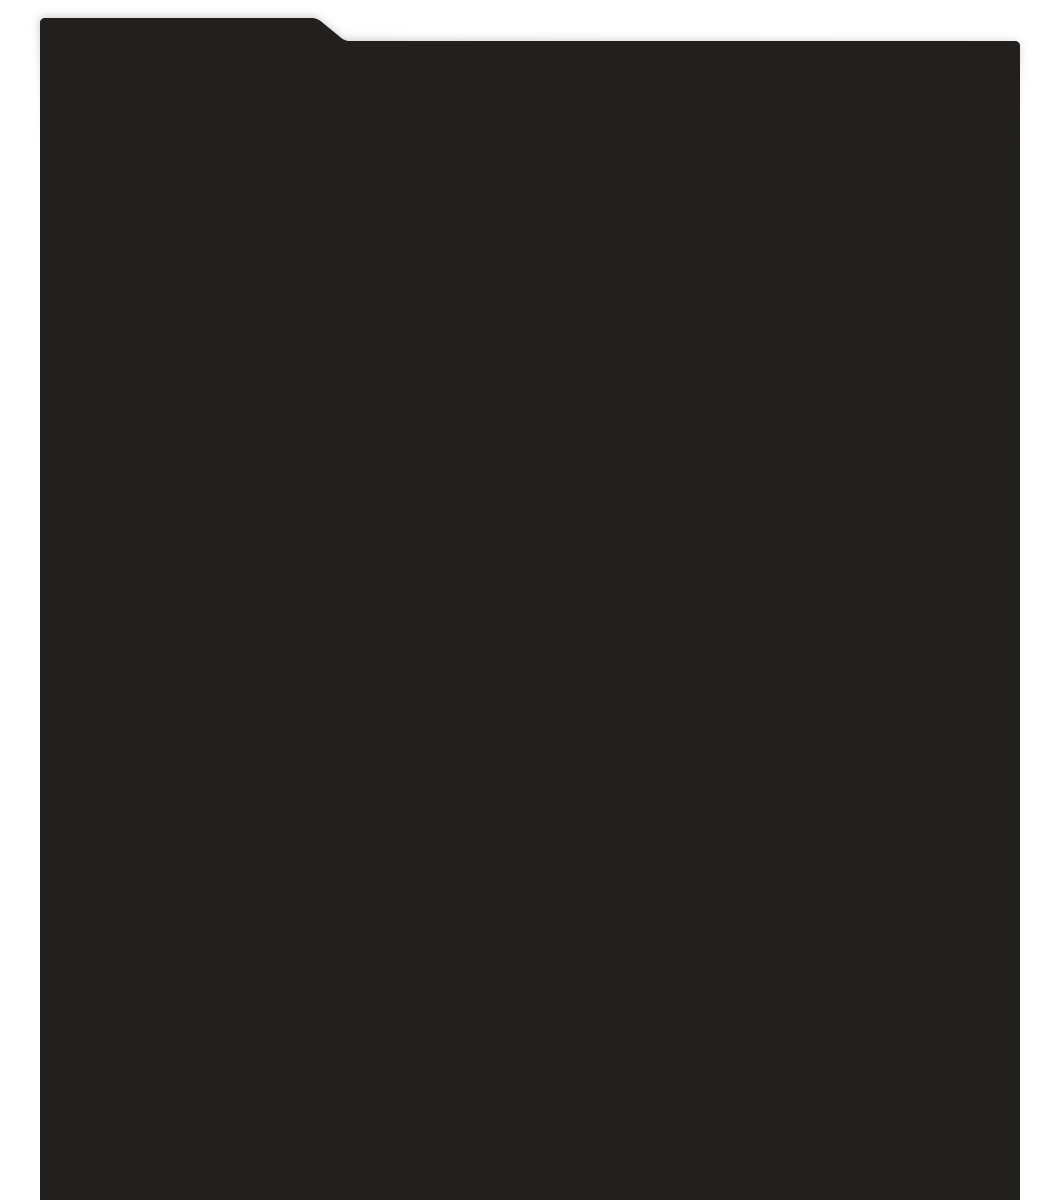
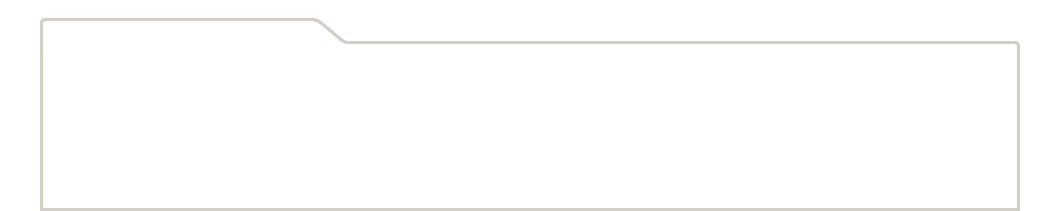
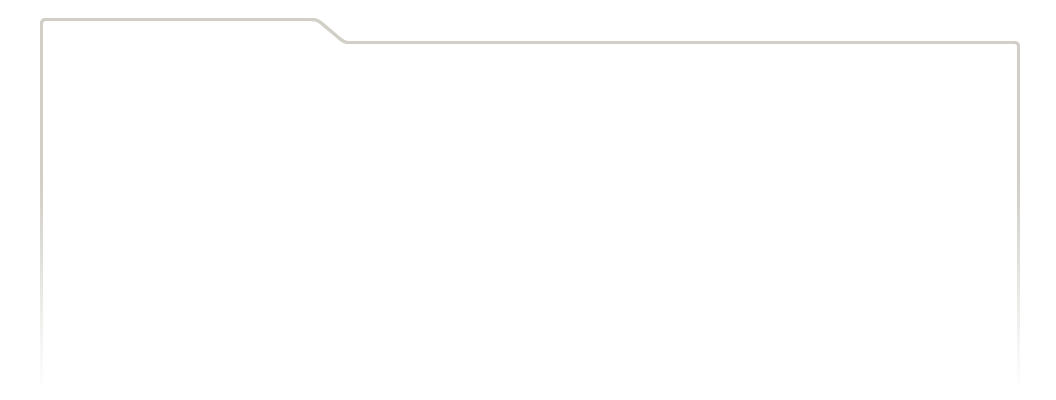
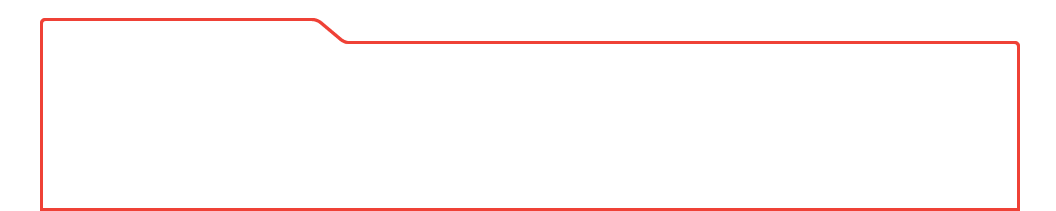
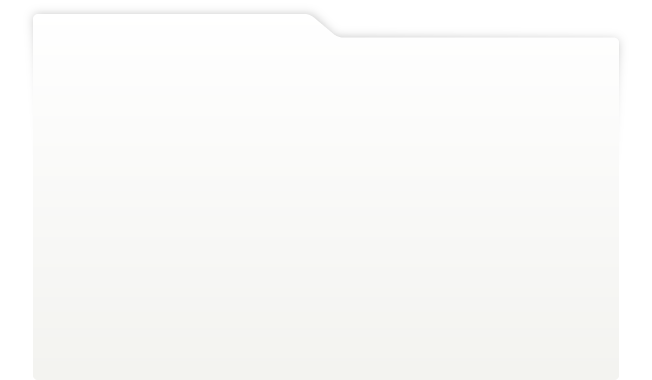
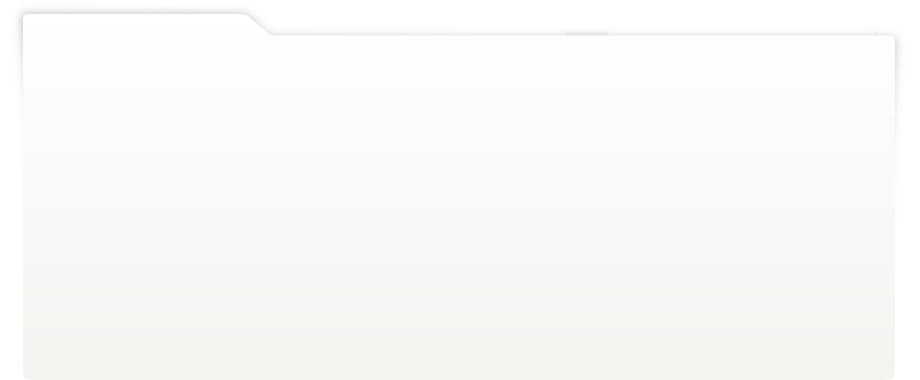
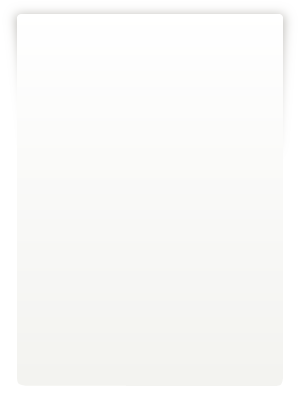
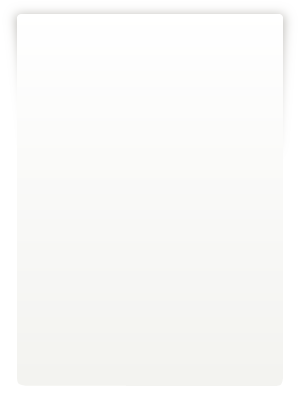
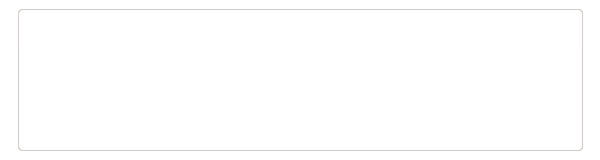
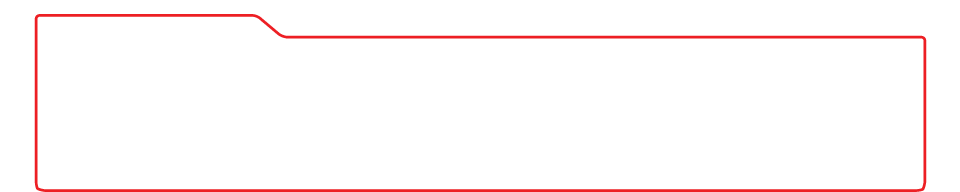
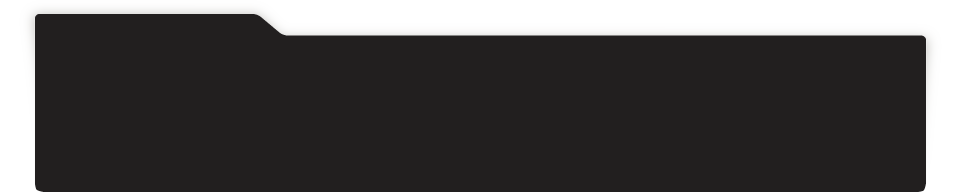
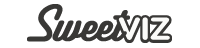
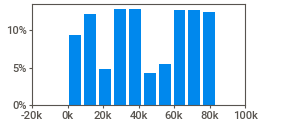
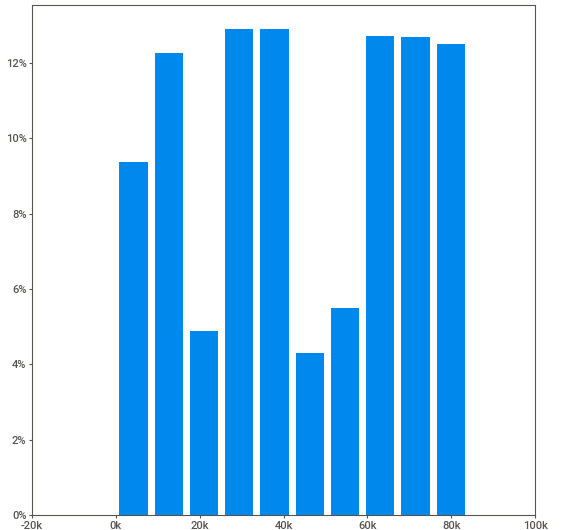
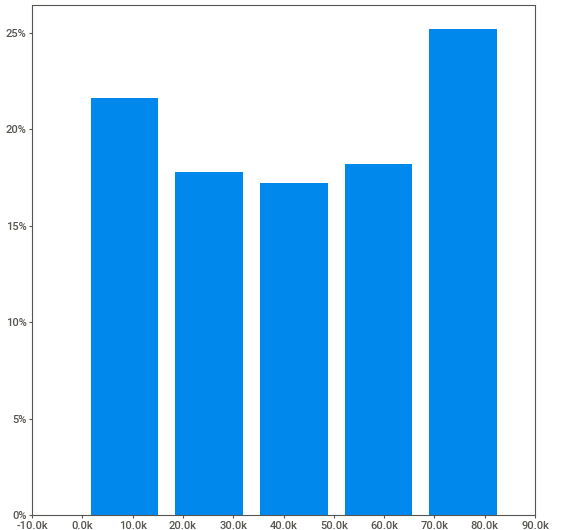
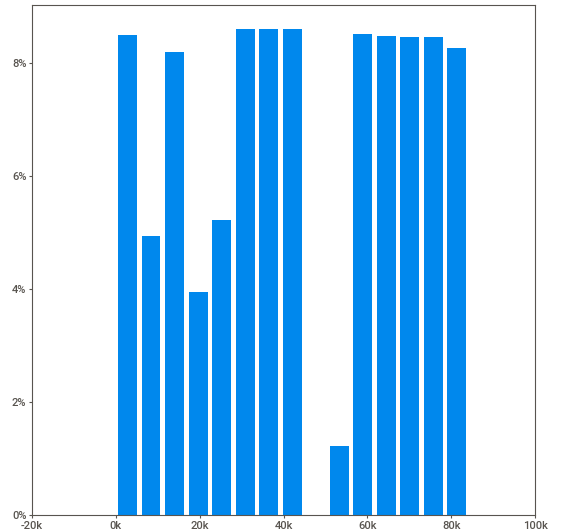
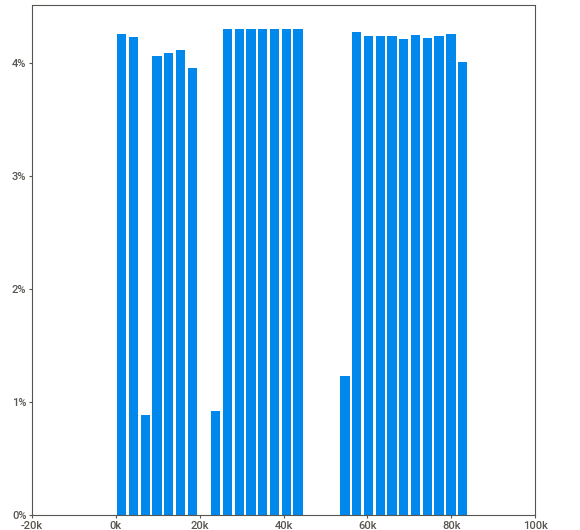
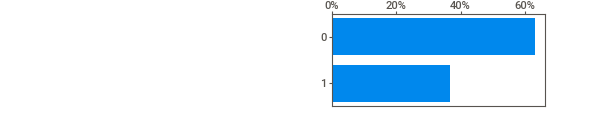
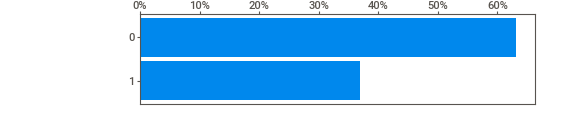
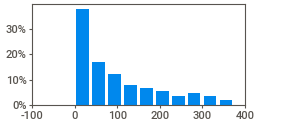
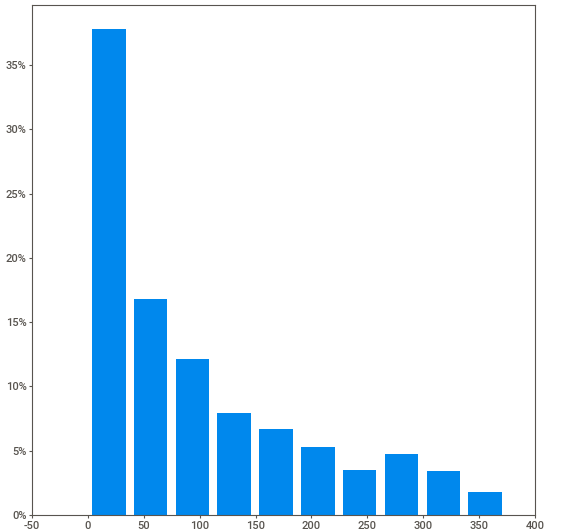
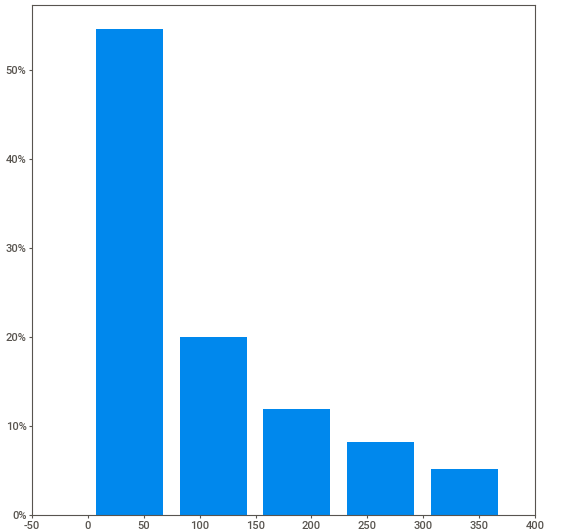
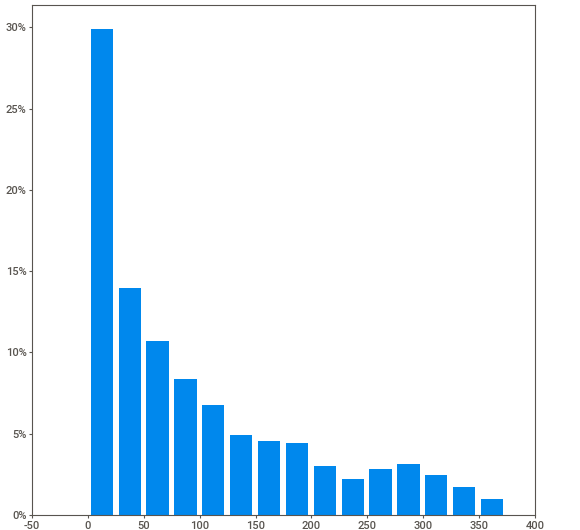
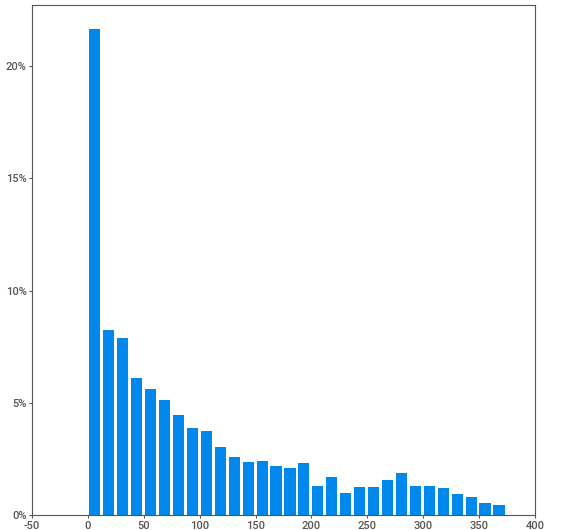
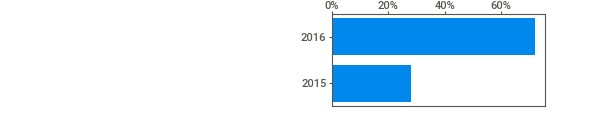
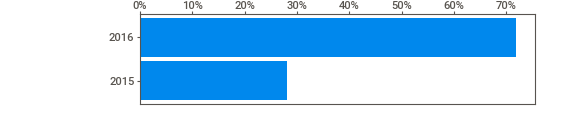
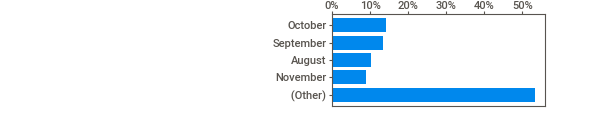
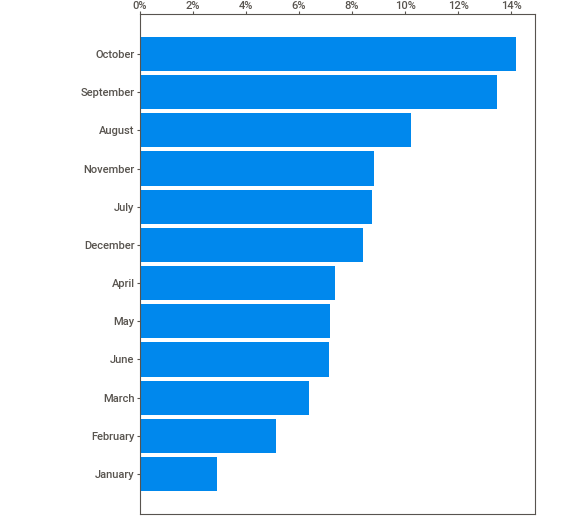
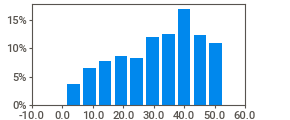
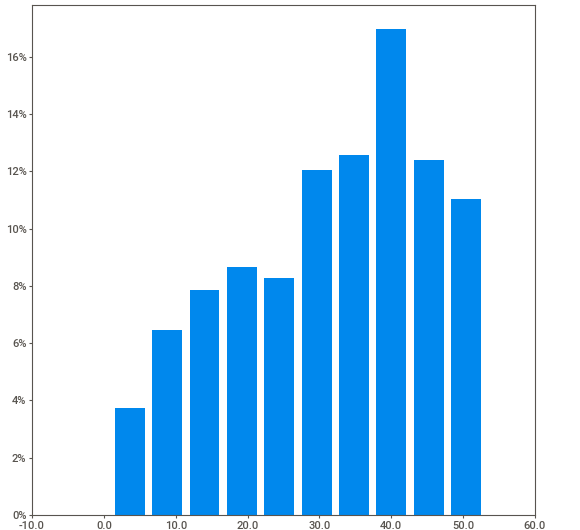
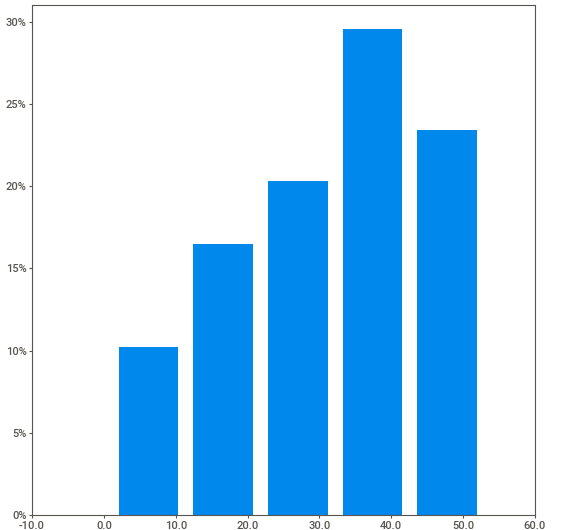
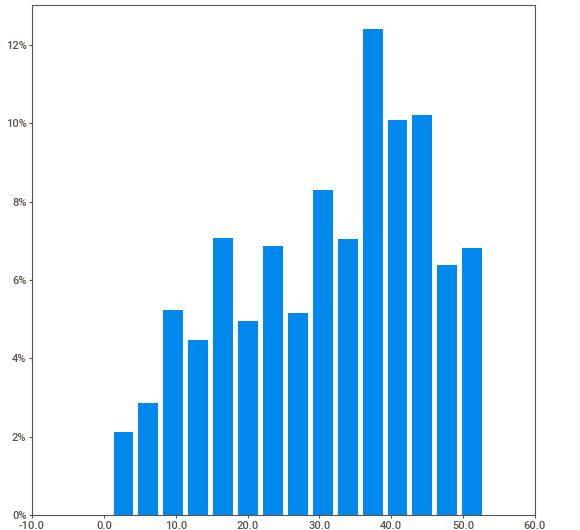
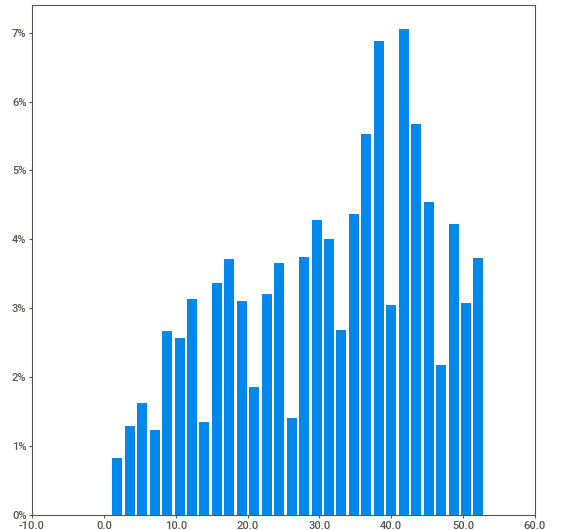
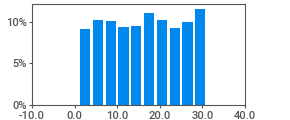
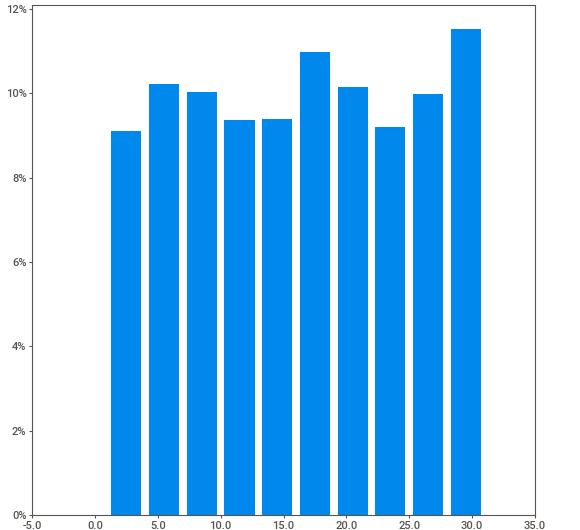
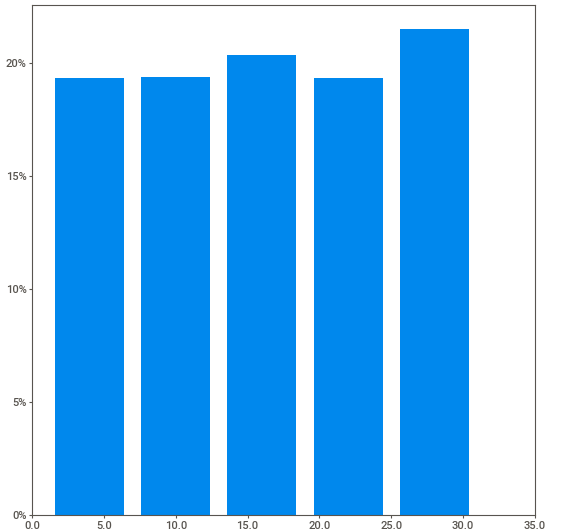
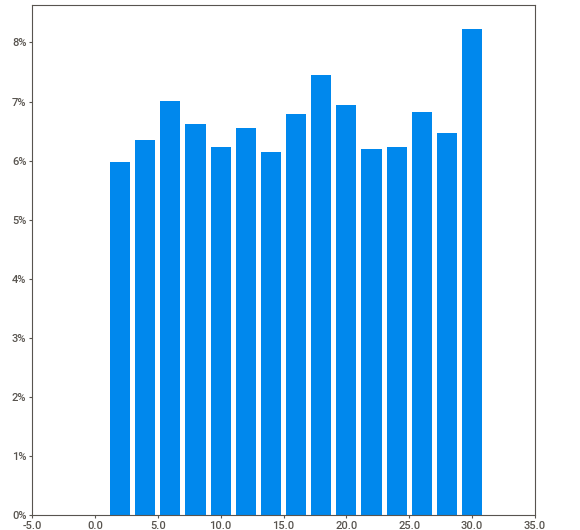
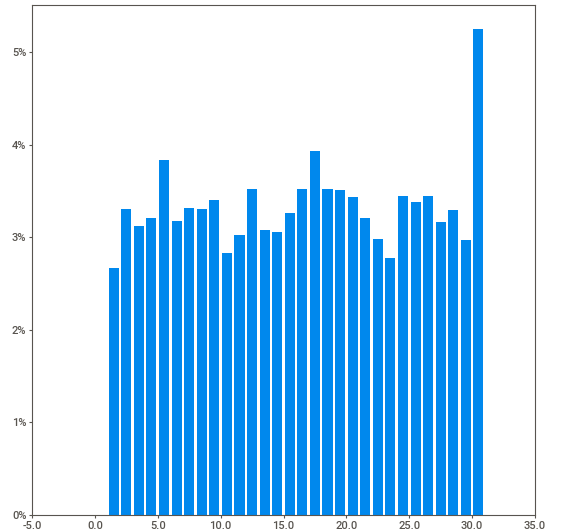
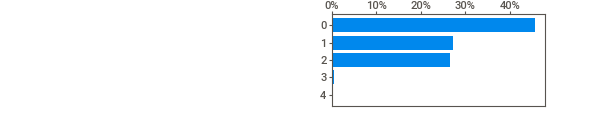
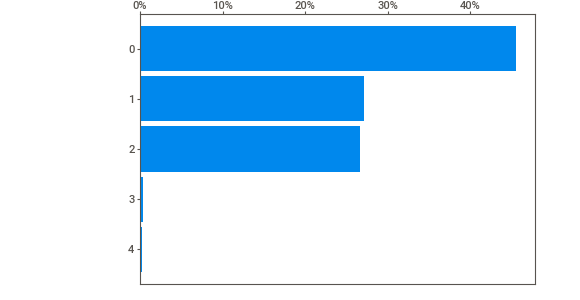
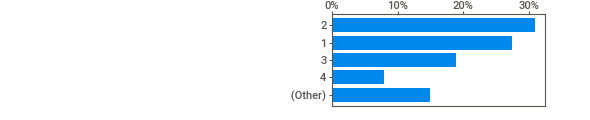
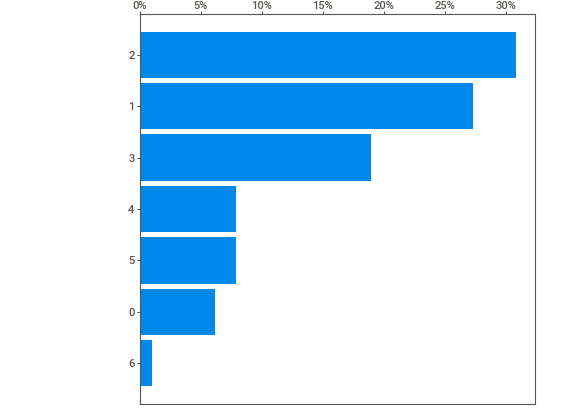
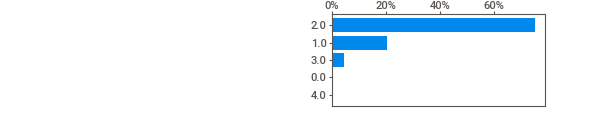
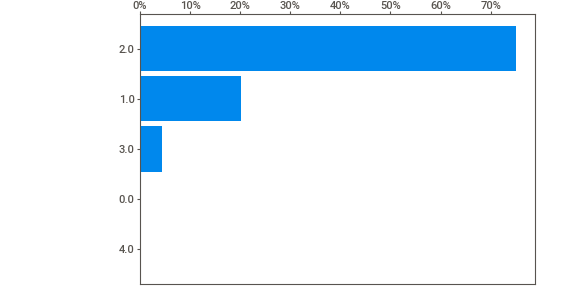
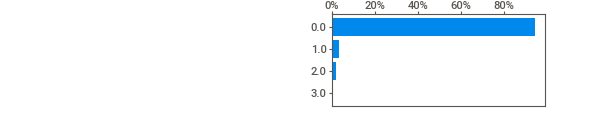
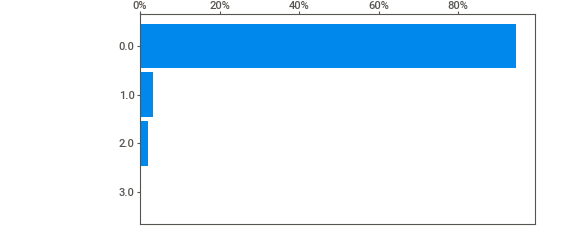
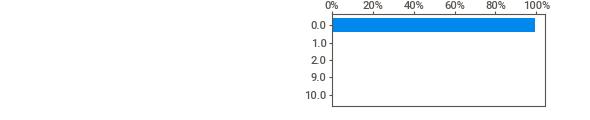
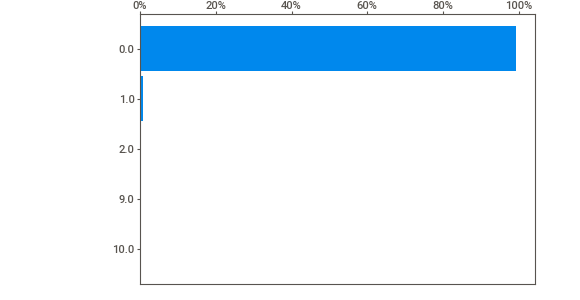
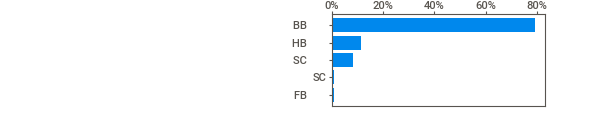
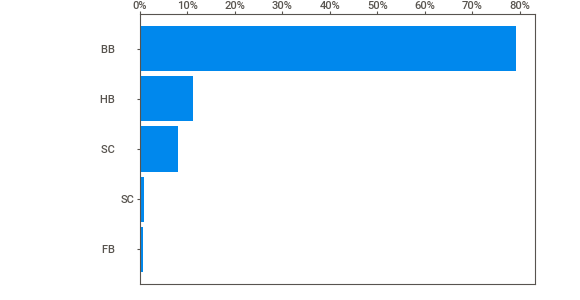
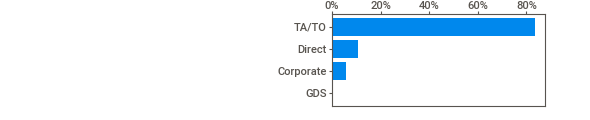
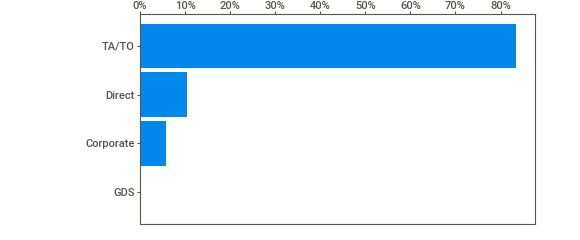
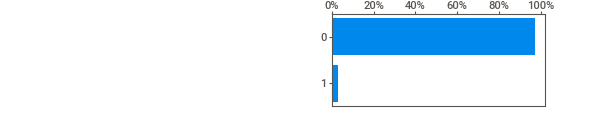
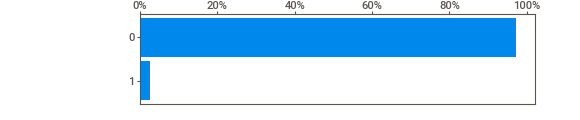
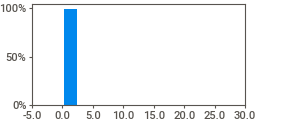
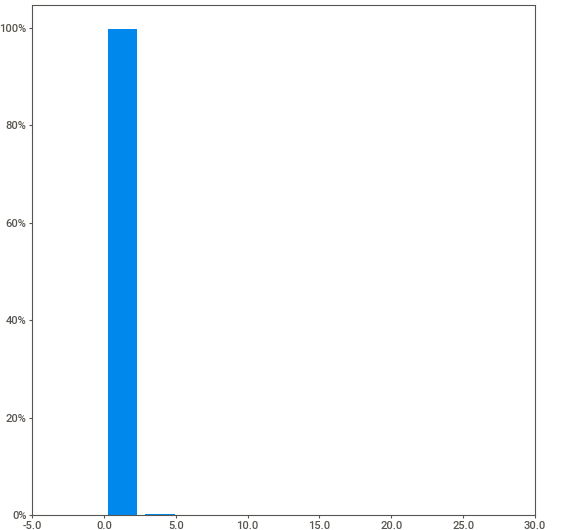
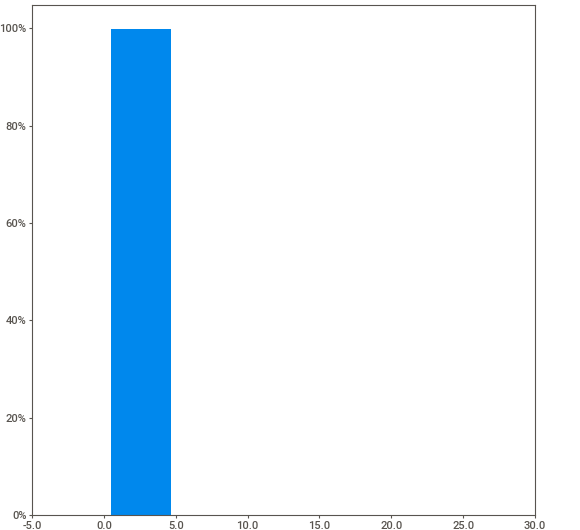
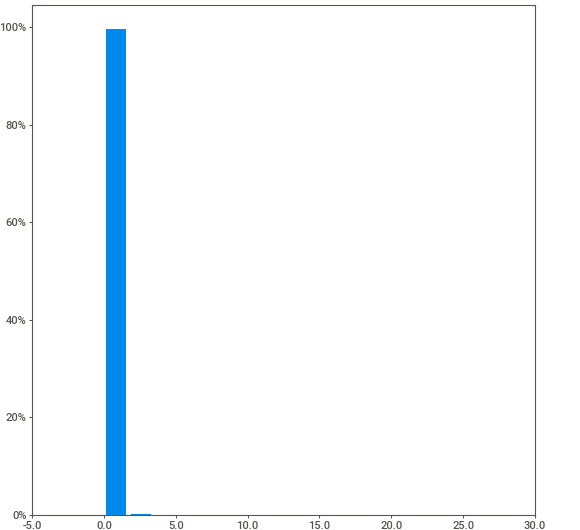
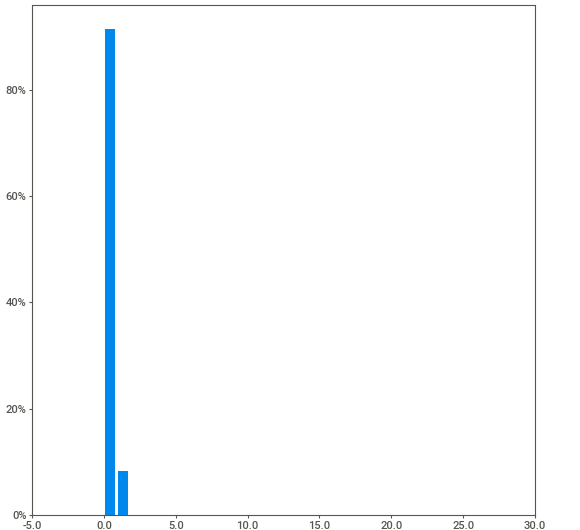
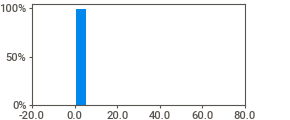
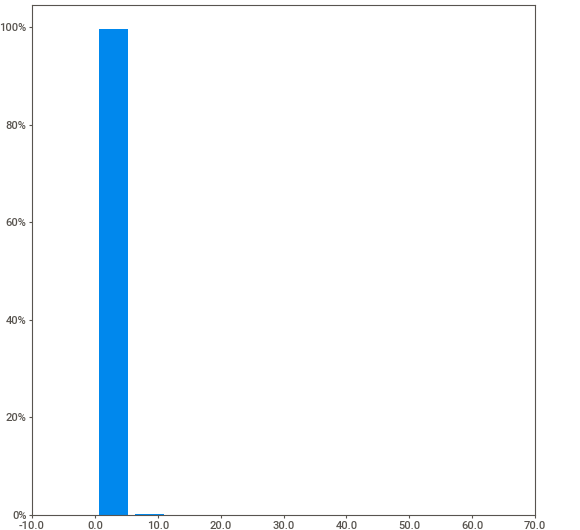
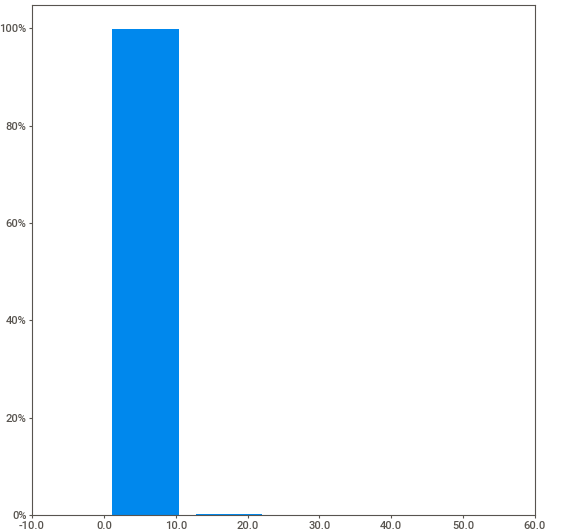
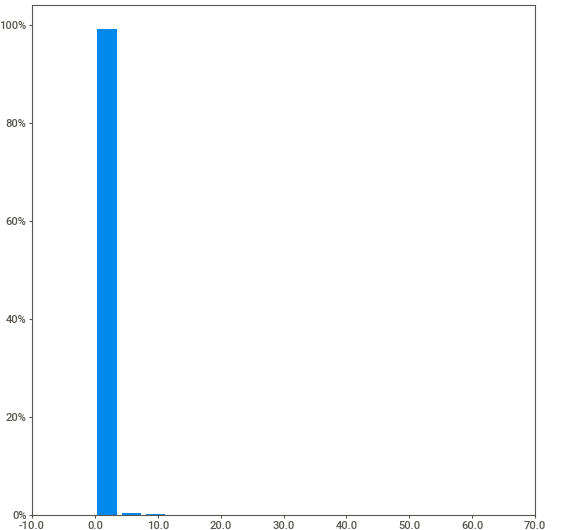
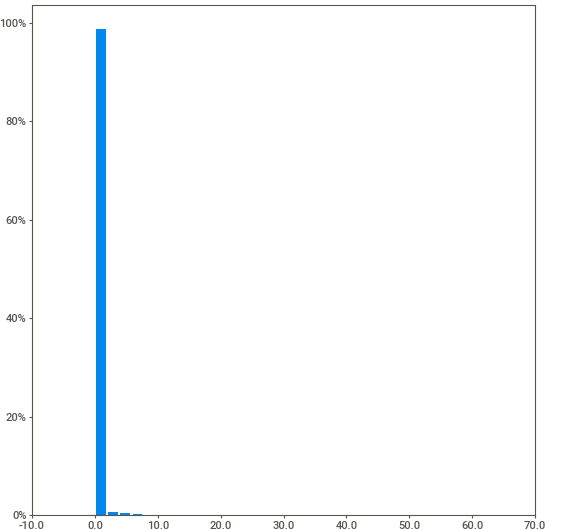
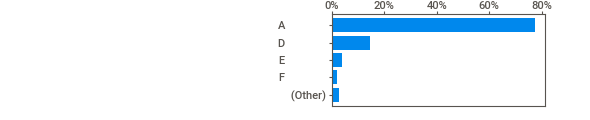
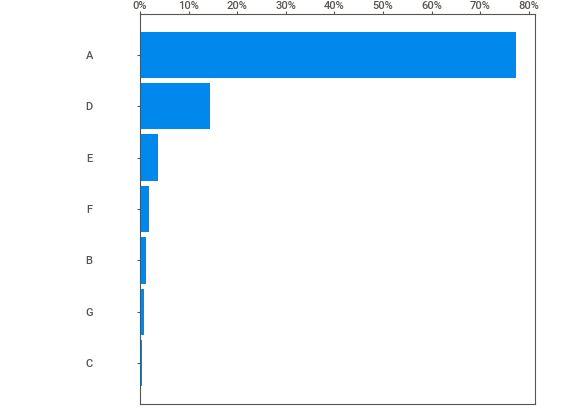
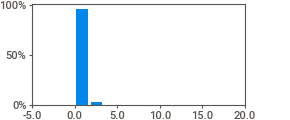
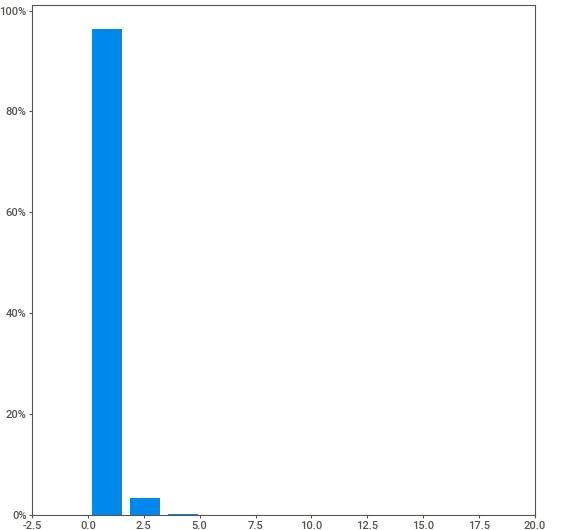
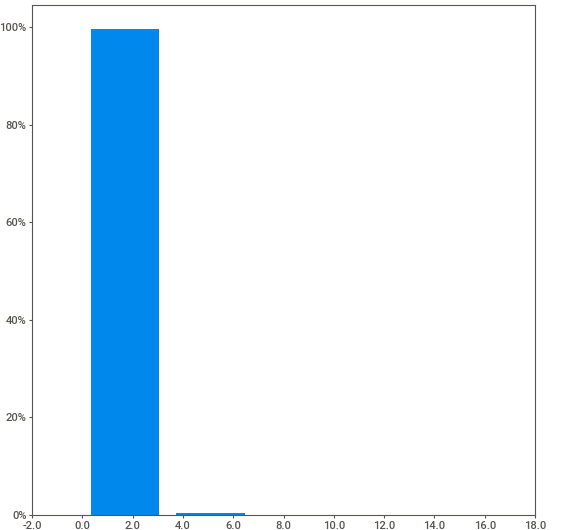
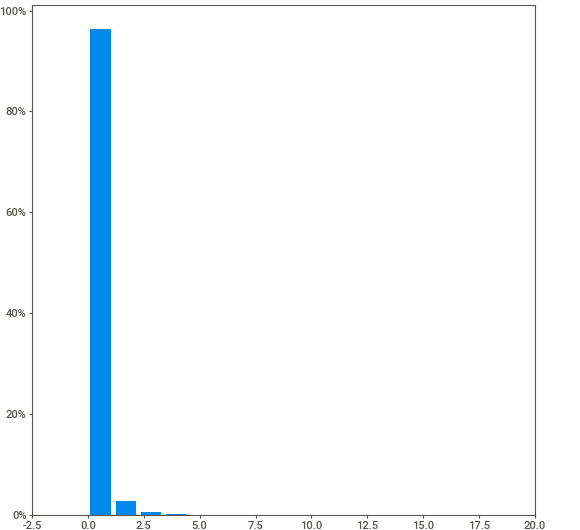
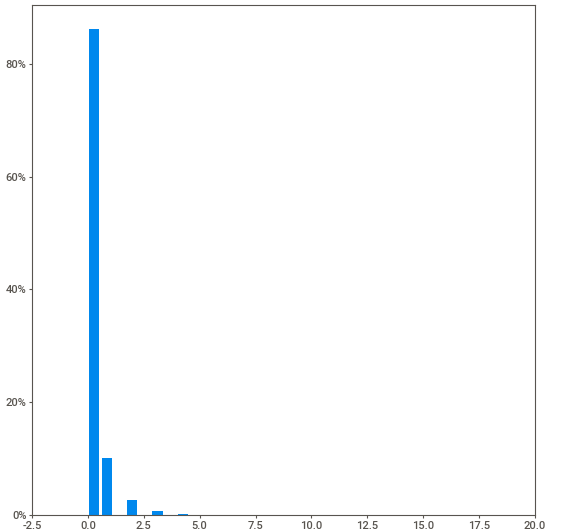
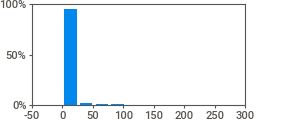
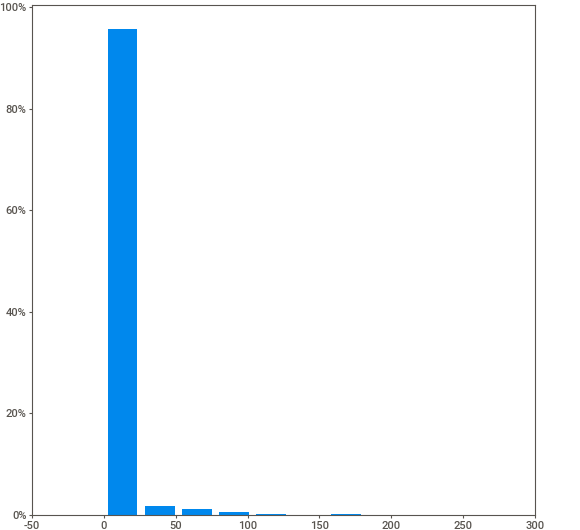
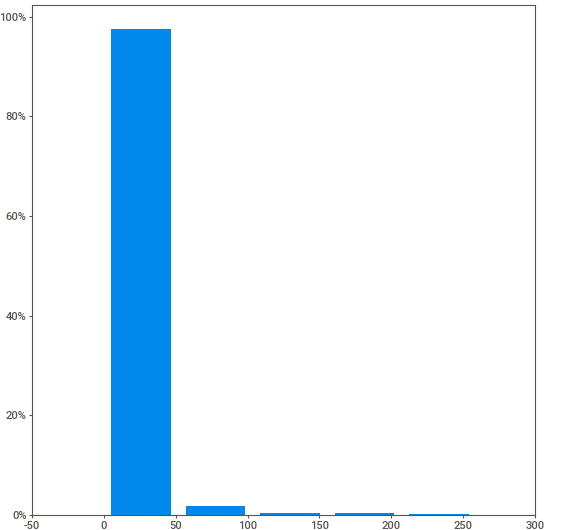
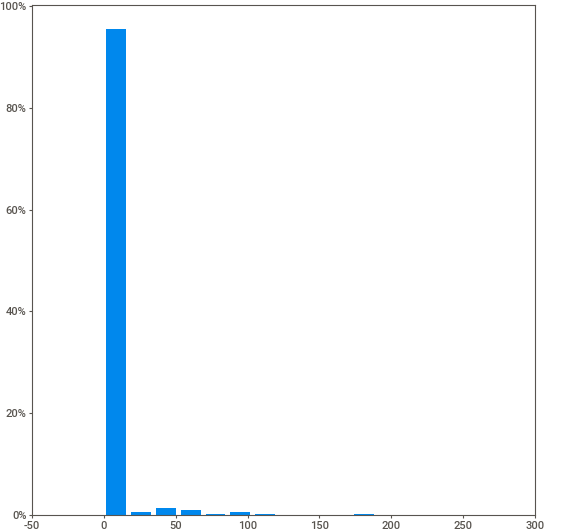
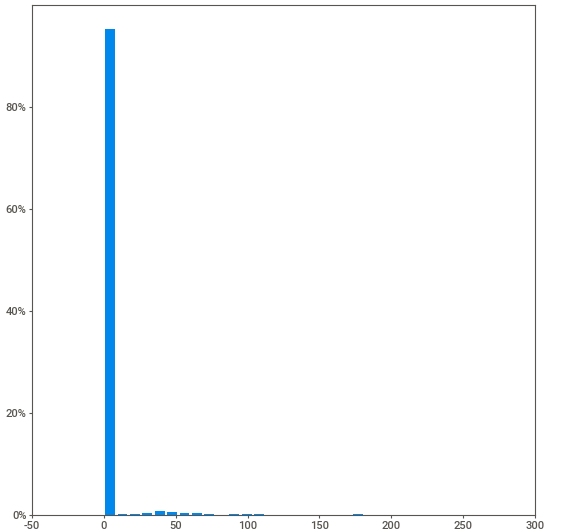
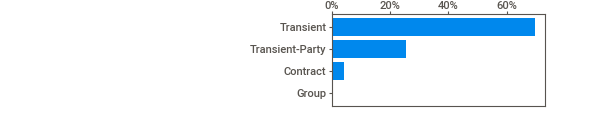
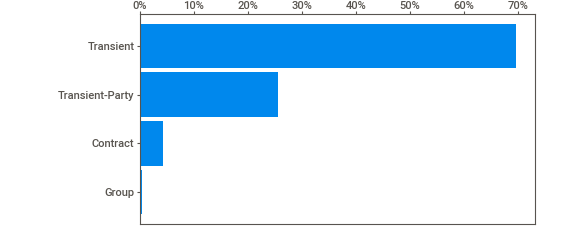
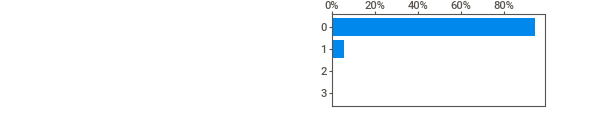
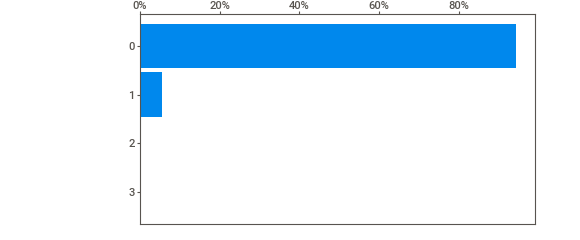
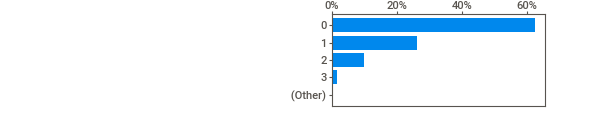
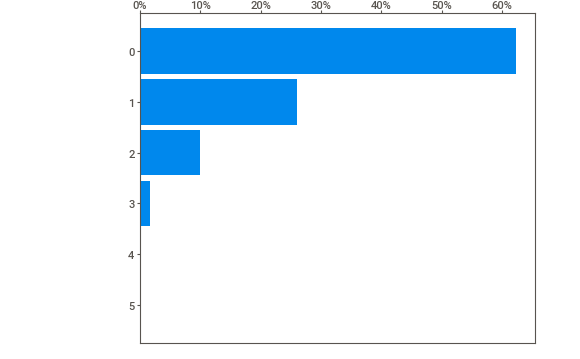
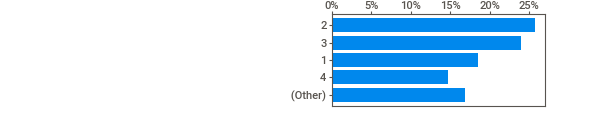
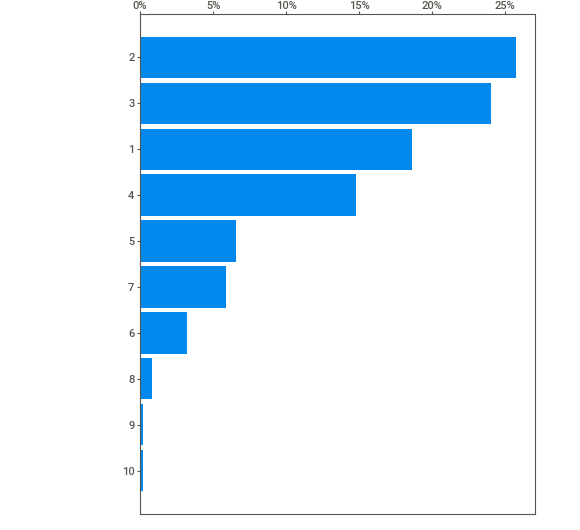
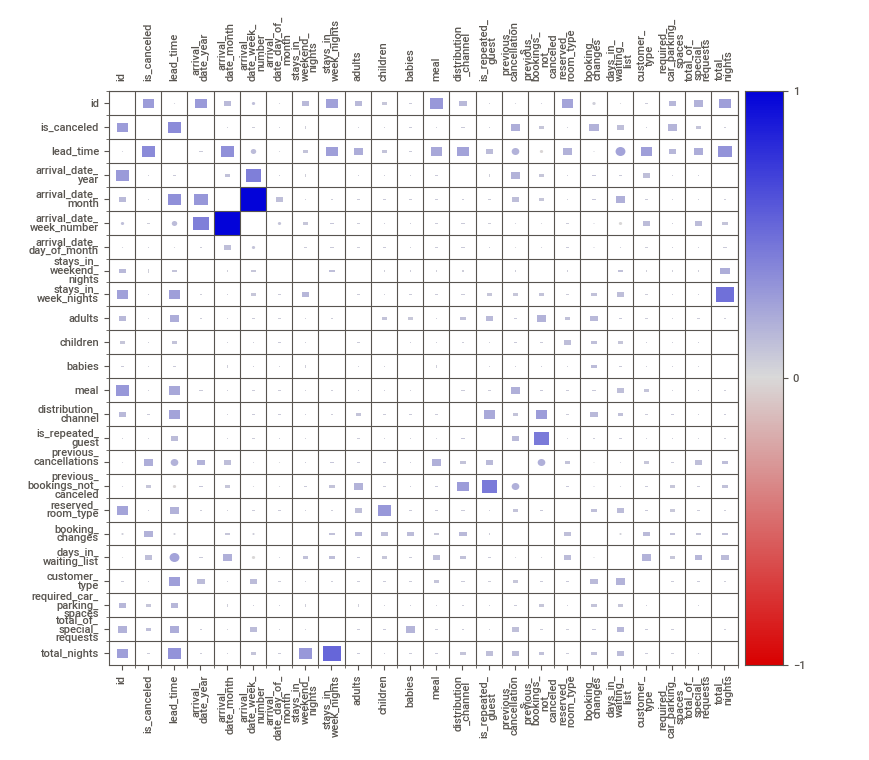
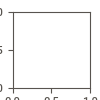

In [13]:
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)

Проверим данные на дубликаты.

In [14]:
print('Количество дубликатов в обучающем датафрейме:', df_train.duplicated().sum())
print('Количество дубликатов в тестовом датафрейме:', df_test.duplicated().sum())

Количество дубликатов в обучающем датафрейме: 0
Количество дубликатов в тестовом датафрейме: 0


Столбец id не содержит полезной информации, удалим его. Колонки lead_time, adults, children и babies содержат целочисленные значения, а имеют вещественный тип float64. Приведём эти столбцы в соответствие их типам. 

In [15]:
df_train.drop(['id'], axis='columns', inplace=True)
df_test.drop(['id'], axis='columns', inplace=True)

In [16]:
print('Количество дубликатов в обучающем датафрейме:', df_train.duplicated().sum())
print('Количество дубликатов в тестовом датафрейме:', df_test.duplicated().sum())

Количество дубликатов в обучающем датафрейме: 21377
Количество дубликатов в тестовом датафрейме: 7717


После удаления столбца id обнаружилось значительно количество полных дубликатов. Но это вполне могли быть несколько бронирований, сделанных одним клиентом в один день. Проверить наверняка мы это не можем. Поэтому удалять не будем.

In [17]:
# приведем столбцы вещественного типа к целочисленному
lst = list(df_train.select_dtypes('float64').columns)
df_train[lst] = df_train[lst].astype('int64')
df_test[lst] = df_test[lst].astype('int64')

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     65229 non-null  int64 
 1   lead_time                       65229 non-null  int64 
 2   arrival_date_year               65229 non-null  int64 
 3   arrival_date_month              65229 non-null  object
 4   arrival_date_week_number        65229 non-null  int64 
 5   arrival_date_day_of_month       65229 non-null  int64 
 6   stays_in_weekend_nights         65229 non-null  int64 
 7   stays_in_week_nights            65229 non-null  int64 
 8   adults                          65229 non-null  int64 
 9   children                        65229 non-null  int64 
 10  babies                          65229 non-null  int64 
 11  meal                            65229 non-null  object
 12  country                         65229 non-null

Проверим категориальные данные на неявные дубликаты.

In [19]:
print(df_train['country'].unique().tolist())

['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL', 'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA', 'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT', 'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA', 'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB', 'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA', 'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS', 'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR', 'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE', 'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP', 'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ', 'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD', 'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA', 'GAB', 'MKD', 'TMP', 'GLP', 'KEN', 'LIE', 'MMR', 'PAN', 'BFA', 'LBY', 'GNB', 'MLI', 'BHR', 'NAM', 'BOL', 'SYC', 'PRY',

In [20]:
cat_columns = df_train.loc[:,  (df_train.dtypes == 'object')].columns

In [21]:
cat_datas = [df_train, df_test] #Проверим категориальные столбцы на скрытые дубликаты
for data in cat_datas:
    for column in cat_columns:
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']
Количество уникальных значений arrival_date_month: 12
['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']
Количество уникальных значений meal: 5
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 'NAM

Число уникальных значений в столбцах meal и distribution_channel не совпадают из-за наличия пробелов, которые необходимо удалить.


Напишем функцию для удаления пробелов.

In [22]:
cat_datas = [df_train, df_test] 
for data in cat_datas:
    for column in ['meal', 'reserved_room_type']:
        data[column] = data[column].str.strip()
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7
['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7


In [23]:
vc = df_train['country'].value_counts(normalize=True)
df_train.loc[df_train['country'].isin(vc[vc < 0.001].index), 'country'] = 'other'
vc = df_test['country'].value_counts(normalize=True)
df_test.loc[df_test['country'].isin(vc[vc < 0.001].index), 'country'] = 'other'


In [24]:

df_train[['lead_time','adults', 'children','babies']] = df_train[['lead_time','adults', 'children', 'babies']].astype(int)
df_test[['lead_time','adults', 'children','babies']] = df_test[['lead_time','adults', 'children', 'babies']].astype(int)

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     65229 non-null  int64 
 1   lead_time                       65229 non-null  int64 
 2   arrival_date_year               65229 non-null  int64 
 3   arrival_date_month              65229 non-null  object
 4   arrival_date_week_number        65229 non-null  int64 
 5   arrival_date_day_of_month       65229 non-null  int64 
 6   stays_in_weekend_nights         65229 non-null  int64 
 7   stays_in_week_nights            65229 non-null  int64 
 8   adults                          65229 non-null  int64 
 9   children                        65229 non-null  int64 
 10  babies                          65229 non-null  int64 
 11  meal                            65229 non-null  object
 12  country                         65229 non-null

In [26]:
df_train['arrival_date_month'] = pd.to_datetime(df_train['arrival_date_month'], format='%B').dt.month
df_test['arrival_date_month'] = pd.to_datetime(df_test['arrival_date_month'], format='%B').dt.month

In [27]:
df_train.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,2015,7,27,1,0,1,1,0,0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14,2015,7,27,1,0,2,2,0,0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0,2015,7,27,1,0,2,2,0,0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9,2015,7,27,1,0,2,2,0,0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85,2015,7,27,1,0,3,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


#### Исследовательский анализ данных

Изучим аномальные значения используя sweetviz отчёт.

Удалим из данных лишние столбцы, не влияющие на формирование модели.
arrival_date_year - всего два года, для следующих лет эта информация бесполезна
arrival_date_week_number - большая вариация выбора, далее создам просто колонку с сезоном года
arrival_date_day_of_month - день месяца будет бесполезен в обучении модели, так как информация изменяется в днях не из-за самих дней, а из-за сезоона
total_nights - не нужен, так как есть кол-во ночей в рабочие и выходные дни


Проверим, выполняется ли условие совпадения суммы дней в stays_in_week_nights и stays_in_weekend_nights с параметрами total_nights.

In [28]:
print('Количество записей, в которых сумма ночей в будние дни и выходные не совпадает:',
      len(df_train.loc[df_train['total_nights'] != df_train['stays_in_week_nights'] + df_train['stays_in_weekend_nights']]))

Количество записей, в которых сумма ночей в будние дни и выходные не совпадает: 0


Количество записей совпадает, total_nights можно удалить.

In [29]:
df_train = df_train.drop(['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month','total_nights'], axis = 1)

df_test = df_test.drop(['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month','total_nights'], axis = 1)

Изучим целевой признак "отменен ли заказ".

In [30]:
df_train['is_canceled'].value_counts(normalize = True)

0    0.631391
1    0.368609
Name: is_canceled, dtype: float64

In [31]:
df_test['is_canceled'].value_counts(normalize = True)

0    0.611533
1    0.388467
Name: is_canceled, dtype: float64

Видно, что выборки не стратифицированные, но расхождение не велико. Кроме того, имеется явный дисбаланс классов - 
более трети клиентов отказавшихся от брони и приблизительно две трети клиентов, которые воспользовались бронированием. 
При моделировании необходимо это учитывать и применять методы балансировки классов.

В столбце "babies" есть по одному значению больше 2х, отбросим выбивающиеся значения.

In [32]:
df_train.drop(df_train[df_train['babies'] > 2].index, inplace=True)
df_test.drop(df_test[df_test['babies'] > 2].index, inplace=True)

Так как младенцев равное 2 в обоих таблицах крайне мало, сделаем из этого столбца признак наличия младенцев. То есть младенцы или есть или их нет вообще. Для этого приравняем количество младенцев равное двум к единице и для корректности переименуем этот столбец в has_babies.

In [33]:
df_train.loc[df_train['babies'] == 2, 'babies'] = 1
df_train.rename(columns={'babies': 'has_babies'}, inplace=True)
df_test.loc[df_test['babies'] == 2, 'babies'] = 1
df_test.rename(columns={'babies': 'has_babies'}, inplace=True)

В столбце previous_cancellations всего 15 уникальных значений, при этом только от 0 до 5 идут непрерывно и имеют существенную частоту. Удалим всё что выше 5.

In [34]:
df_train.drop(df_train[df_train['previous_cancellations'] > 5].index, inplace=True)
df_test.drop(df_test[df_test['previous_cancellations'] > 5].index, inplace=True)

В столбце previous_bookings_not_canceled значения распределены от 0 до 50, но значений выше 20 лишь 55.
Отбросим строчки со значением выше 20.

In [35]:
df_train.drop(df_train[df_train['previous_bookings_not_canceled'] > 20].index, inplace=True)
df_test.drop(df_test[df_test['previous_bookings_not_canceled'] > 20].index, inplace=True)

В столбце booking_changes отбросим значения выше 10.

In [36]:
df_train.drop(df_train[df_train['booking_changes'] > 10].index, inplace=True)
df_test.drop(df_test[df_test['booking_changes'] > 10].index, inplace=True)

В столбце required_car_parking_spaces отбросим значения выше 1.

In [37]:
df_train.drop(df_train[df_train['required_car_parking_spaces'] > 1].index, inplace=True)
df_test.drop(df_test[df_test['required_car_parking_spaces'] > 1].index, inplace=True)

Показатель дни ожидания бронирования имеет очень длинный "хвост", уберем показатели более 100 дней.

In [38]:
df_train = df_train.query('days_in_waiting_list < 100') 
df_test = df_test.query('days_in_waiting_list < 100')

Проверим невозможные варианты бронирования.

Бронирование номеров детьми без взрослых.

In [40]:
df_train.query('(children > 0 | has_babies > 0) & adults == 0').shape[0]

151

Значения присутствуют, произведем их удаление.

In [41]:
df_train.drop(df_train.query('(children > 0 | has_babies > 0) & adults == 0').index, inplace=True)
df_test.drop(df_test.query('(children > 0 | has_babies > 0) & adults == 0').index, inplace=True)

Заселение без людей.

In [42]:
df_train.drop(df_train.query('adults == 0').index, inplace=True)
df_test.drop(df_test.query('adults == 0').index, inplace=True)

Обновим индексы.

In [43]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

Сделаем дополнительный столбец с указанием сезона бронирования.

In [44]:
def season(month):
    if month == 9 or month == 10 or month == 11:
        return 'autumn'
    if month == 6 or month == 7 or month == 8:
            return 'summer'
    if month == 3 or month == 4 or month == 5:
        return 'spring'
    if month == 1 or month == 2 or month == 12:
        return 'winter'

In [45]:
df_train['season'] = df_train['arrival_date_month'].apply(season)
df_test['season'] = df_test['arrival_date_month'].apply(season)

In [46]:
df_train.tail(5)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season
64274,0,23,12,2,4,2,0,0,BB,CHN,TA/TO,0,0,0,D,0,0,Transient,0,2,winter
64275,0,53,12,2,3,2,0,0,HB,FRA,TA/TO,0,0,0,D,0,0,Transient,0,3,winter
64276,0,7,12,2,4,2,0,0,BB,FRA,TA/TO,0,0,0,D,0,0,Transient,0,1,winter
64277,0,17,12,2,5,2,0,0,SC,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,winter
64278,0,107,12,2,5,2,0,0,BB,FRA,TA/TO,0,0,0,A,0,0,Transient,0,0,winter


Рассмотрим распределение бронирования по сезонам.

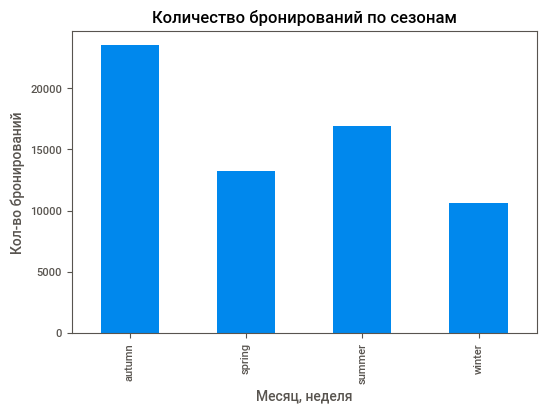

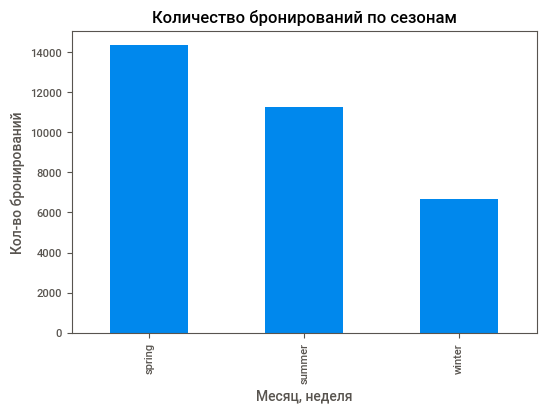

In [47]:
datas = [df_train, df_test]
AX = 0
for data in datas:
    data.pivot_table(index=[ 'season'],
                            values='is_canceled', aggfunc='count').plot(kind ='bar', legend=None)
    plt.xlabel('Месяц, неделя')
    plt.ylabel('Кол-во бронирований')
    plt.title(f'Количество бронирований по сезонам', fontweight="bold")
    AX += 1
    plt.show()

In [48]:
df_test['arrival_date_month'].value_counts()

5    5241
4    4854
6    4563
3    4257
7    3601
2    3531
1    3127
8    3087
Name: arrival_date_month, dtype: int64

Посмотрим корреляцию между признаками.

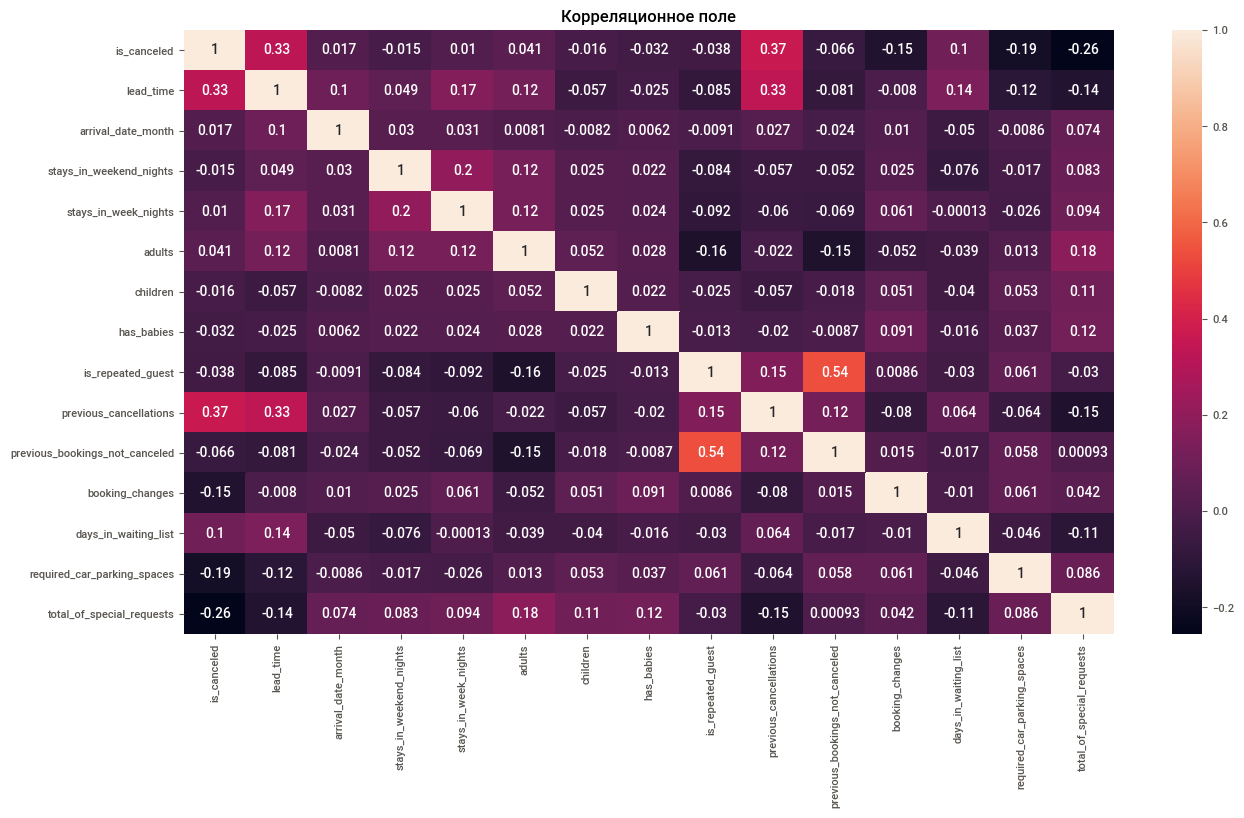

In [49]:
plt.figure(figsize=(15,8))
sns.heatmap(df_train.corr(), annot = True)
plt.title('Корреляционное поле')
plt.show()

Проведем более глуюокий анализ методом phik.

interval columns not set, guessing: ['is_canceled', 'lead_time', 'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'has_babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']


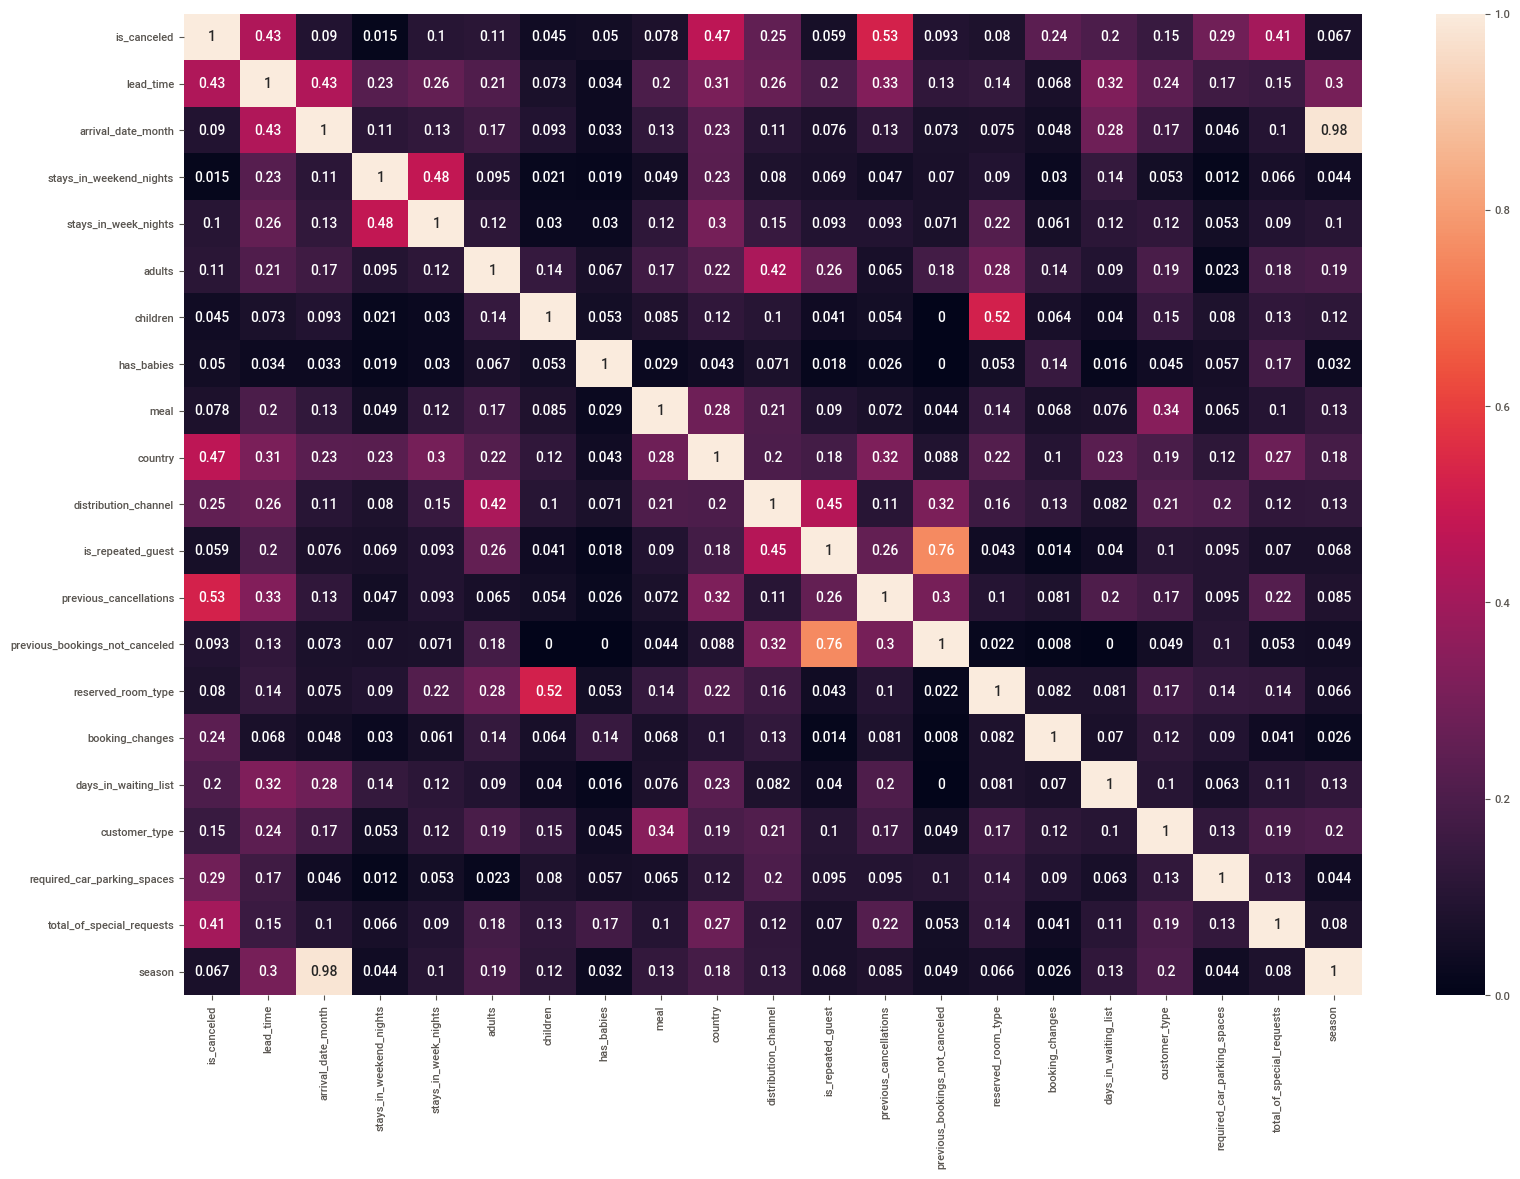

In [50]:
plt.figure(figsize=(19,13))
phik_overview = df_train.phik_matrix()
sns.heatmap(phik_overview.round(3), annot = True)
plt.show()

Проведена преобработка данных. Установлено, что в данных отсутствуют пропуски и дубликаты. Устранены неявные признаки, связанные с пробелами в названиях. Изменен тип данных для категориальных значений. Из данных удалены лишние столбцы, не влияющие на формирование модели. Удалены явные выбросы и нестыковки в данных, такие как бронирование детьми без взрослых, количество детей 10 и т.д.
Для проведения исследовательского анализа получен отчет методом sweetwiz. Определены прямые и косвенные корреляции между признаками.
По результатам исследовательского анализа установлено:
Отменяется 37-39 % брони.
Мы наблюдаем некий дисбаланс целевого признака, который нужно в дальнейшем уравнять, хотя он не является критичным.
На значение целевого показателя по отменам бронирования наибольшее влияние оказывают время от бронирования до заселения и предыдущие отмены. Дополнительно определено, что на целевой показатель также влияют страна клиента и количество специальных отметок.
Положительно на ситуацию с отменой брони влияют такие показатели как количество специальных отметок, необходимость места для автомобиля, количество изменений параметров заказа, регулярность посещения гостем отеля и количество подтверждённых заказов у клиента.
Пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году.
Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.


### Шаг 4. Разработка модели ML

#### Формулировка ML-задачи и вычисление бизнес-метрики

Оценка прибыли отеля без внедрения депозитов.

In [51]:
BUDGET = 400_000
rooms = pd.DataFrame({'A':[1000, 400],       # для каждого типа комнаты присвоим цену за ночь и за уборку
                     'B':[800, 350],
                     'C':[600, 350],
                     'D':[550, 150],
                     'E':[500, 150],
                     'F':[450, 150],
                     'G':[350, 150]}, index = ['night_price', 'service'])
season_ratio = pd.DataFrame({'summer':[1.4],   #   для каждого сезона присвоим коэффициент
                           'autumn':[1.2],
                           'spring':[1.2],
                            'winter':[1]}, index = ['ratio'])

Напишем функцию для подсчета прибыли.

In [52]:
def revenue(data):      
    room_type = data['reserved_room_type']
    season = data['season']
    total_nights = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
    is_canceled = data['is_canceled']
    
    room_price = rooms[room_type].night_price
    service_price = rooms[room_type].service
    ratio_for_price = season_ratio[season].ratio
   
    
    if is_canceled:
        profit = -ratio_for_price * ( room_price) - service_price
    else:
        # если человек приехал на одну ночь, надо убраться только после его приезда для след. покупателя. 1 уборка 
        # Если на две ночи то убирают только после приезда для след. постояльца 1 уборка
        # Если три дня, то убирают каждый второй день, то есть 1 раз и после для след. покупателя 2 уборки
        # Если на 4 дня - то всего две уборки и так далее
        profit = ratio_for_price * (total_nights*room_price) - ((1 + total_nights) // 2) * service_price 
    
    
    return profit

total_revenue = df_test.apply(revenue, axis = 1).sum() - BUDGET

In [53]:
print('Прибыль отеля без внедрения депозитов равна ', total_revenue / 1000000, 'млн.руб.')

Прибыль отеля без внедрения депозитов равна  34.6869 млн.руб.


In [54]:

print('Прибыль с внедренияим депозитов должна быть >=', total_revenue / 1000000 + BUDGET / 1000000, 'млн.руб.')

Прибыль с внедренияим депозитов должна быть >= 35.0869 млн.руб.


Показатель необходимой прибыли определен, перейдем к обучению моделей.

#### Разработка моделей ML

In [55]:
df_test1 = df_test.copy()

In [56]:
df_train = df_train.drop('season', axis = 1) # удалим сезоны, так как у нас уже есть месяца



In [57]:
df_train.head(2)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,0,7,7,0,1,1,0,0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0
1,0,14,7,0,2,2,0,0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1


In [58]:
df_test = df_test.drop('season', axis = 1)

In [59]:
df_test.head(2)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,1,74,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0
1,1,62,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1


Отделим целевой признак от выборок.

In [60]:
features_train = df_train.drop('is_canceled', axis=1)
target_train = df_train['is_canceled']

features_test = df_test.drop('is_canceled', axis=1)
target_test = df_test['is_canceled']

Закодируем порядковые переменные.

In [61]:

reserved_room_type_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
meal_categories = ['SC', 'BB', 'HB', 'FB']

encoder = OrdinalEncoder(categories=[reserved_room_type_categories, meal_categories], dtype='int')
encoder.fit(df_train[['reserved_room_type', 'meal']])

df_train[['reserved_room_type', 'meal']] = encoder.transform(df_train[['reserved_room_type', 'meal']])
df_test[['reserved_room_type', 'meal']] = encoder.transform(df_test[['reserved_room_type', 'meal']])

переведем категориальные признаки в числовые с помощью OneHotEncoder.

In [62]:
obj_features = features_train.select_dtypes(include='object').columns.to_list()  # столбцы типа object
num_features = features_train.select_dtypes(exclude='object').columns.to_list()  # столбцы типа int or float
print('objects: \n', obj_features)
print('nums: \n', num_features)
# используем технику OneHotEncoder для работы с строковыми значениями
encoder = OneHotEncoder(handle_unknown = 'ignore',drop = 'first', sparse = False) 

encoder.fit(features_train[obj_features])

features_train[
    encoder.get_feature_names_out()
] = encoder.transform(features_train[obj_features])

features_train = features_train.drop(obj_features, axis = 1)


features_test[
    encoder.get_feature_names_out()
] = encoder.transform(features_test[obj_features])

features_test = features_test.drop(obj_features, axis = 1)


objects: 
 ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
nums: 
 ['lead_time', 'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'has_babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']


Стандартизируем данные.

In [88]:
scaler = StandardScaler() # стандартизиуем данные
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [89]:
features_train.head(3)

,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,meal_FB,meal_HB,meal_SC,country_ARG,country_AUS,country_AUT,country_BEL,country_BRA,country_CHE,country_CHN,country_CN,country_CZE,country_DEU,country_DNK,country_ESP,country_FIN,country_FRA,country_GBR,country_GRC,country_HUN,country_IND,country_IRL,country_ISR,country_ITA,country_JPN,country_KOR,country_LUX,country_MAR,country_NLD,country_NOR,country_POL,country_PRT,country_ROU,country_RUS,country_SRB,country_SWE,country_TUR,country_USA,country_other,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
11546,-0.339712,-1.135031,1.379451,2.081695,0.328037,-0.216268,-0.077753,-0.156821,-0.366610,-0.091087,-0.305995,-0.206463,-0.208363,-0.618958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39404,1.506901,0.495999,0.208472,-0.167155,-1.833118,-0.216268,-0.077753,-0.156821,2.590843,-0.091087,1.578271,-0.206463,-0.208363,-0.618958,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42373,-0.721077,1.474617,-0.962507,-0.167155,-1.833118,-0.216268,-0.077753,-0.156821,2.590843,-0.091087,-0.305995,-0.206463,-0.208363,-0.618958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Далее нужно определить подходящую модель. Целевой показатель для нас - recall, так как от него зависят убытки компании. Чем более точно модель будет предсказывать "отказников", тем меньше убытков понесет компания.

Создадим Dummy Classifier для проверки моделей на адекватность.

In [90]:
dummy_model = DummyClassifier(random_state=1)
dummy_model.fit(features_train, target_train)
prediction_dummy = dummy_model.predict(features_test)
print("Accuracy:", accuracy_score(target_test, prediction_dummy))
print("F1:", f1_score(target_test, prediction_dummy))
print("ROC_auc:", roc_auc_score(target_test, prediction_dummy))
dummy_proba = dummy_model.predict_proba(features_test)[:, 1]
fpr_dummy, tpr_dummy, threshold_dummy = roc_curve(target_test, dummy_proba)

Accuracy: 0.3890145996714299
F1: 0.56013032514338
ROC_auc: 0.5


Строим функцию для постройки ROC-AUC графика.

In [91]:
def rocauc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

Создадим функцию для сверки результатов.

In [92]:
def results(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)
    rocauc(fpr, tpr)
    print("Accuracy:", round(accuracy_score(target, prediction), 3))
    print("F1:", round(f1_score(target, prediction), 3))
    print("ROC_auc:", round(roc_auc_score(target, prediction), 3))
    print("Precision:", round(precision_score(target, prediction), 3))
    print("Recall:", round(recall_score(target, prediction), 3))
    return prediction

Исследуем модель дерева решений.

In [96]:
rec = 0
cw = ['balanced', None]
for weight in cw:
    for depth in tqdm_notebook(range(1, 11)):
        for split in tqdm_notebook(range(2, 5)):
            for leaf in tqdm_notebook(range(1, 5)):
                    model = DecisionTreeClassifier(random_state = 42, max_depth = depth,
                                                  class_weight = weight, min_samples_split = split,
                                                  min_samples_leaf = leaf)
                    scores = cross_val_score(model,features_train, target_train, cv=5, scoring='recall')
                    final_score = sum(scores)/len(scores)
                    if final_score > rec:
                        params_1 = model.get_params()
                        rec = final_score                    
print('средняя оценка recall качества модели:', rec, 'при параметрах:')
print(params_1)





  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

средняя оценка recall качества модели: 0.8349301217315533 при параметрах:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 99, 'splitter': 'best'}


Рассмотрим модель логистической регрессии.

In [97]:
rec = 0 
p = ['l1', 'l2']
for class_weight in cw:
    for penalty in p:
        for cc in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
            model = LogisticRegression(random_state = 42, max_iter = 500000, solver = 'liblinear', class_weight = class_weight,
                                      penalty = penalty, C = cc)
            scores = cross_val_score(model, features_train, target_train, cv = 5, scoring = 'recall')
            final_score = sum(scores) / len(scores)
            if final_score > rec:
                rec = final_score
                params_2 = model.get_params()
print('средняя оценка recall модели:', rec, '    при параметрах:')
print(params_2)

средняя оценка recall модели: 0.8532028870082717     при параметрах:
{'C': 1e-05, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 99, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Исследуем модель случайного леса.

In [98]:
rec = 0
for depth in tqdm_notebook(range(1, 11)):
    for class_weight in cw:
        for estimators in (1, 50):
            model = RandomForestClassifier(
                random_state = 42, class_weight = class_weight, n_estimators = estimators,
                max_depth = depth)
            scores = cross_val_score(model, features_train, target_train, cv = 5, scoring = 'recall')
            final_score = sum(scores) / len(scores)
            if final_score > rec :
                rec = final_score
                params_3 = model.get_params()
print('средняя оценка recall качества модели:', rec, '   достигается при параметрах:')
print(params_3)

  0%|          | 0/10 [00:00<?, ?it/s]

средняя оценка recall качества модели: 0.97714841030408    достигается при параметрах:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Сделаем предсказания оттока клиентов по модели дерева решений.

In [100]:
model = RandomForestClassifier(**params_3)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
predictions_prob = model.predict_proba(features_test)

recall = recall_score(target_test, predictions)
f1 = f1_score(target_test, predictions)
auc_roc = roc_auc_score(target_test, predictions_prob[:, 1])
accuracy = accuracy_score(target_test, predictions)

print('recall', recall)
print('f1', f1)
print('auc-roc', auc_roc)
print('accuracy', accuracy)

recall 0.9543426294820717
f1 0.5643937608972245
auc-roc 0.5227296324316655
accuracy 0.4269241499023589


Добавим предсказания в первоначальную тестовую выборку.

In [106]:
df_test1['predictions'] = predictions

In [107]:
df_test1.head(3)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season,predictions
0,1,74,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,winter,1
1,1,62,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,winter,1
2,1,62,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,winter,1


#### Подсчет выручки по предсказаниям модели

Применим функцию подсчета выручки с учетом предсказаний отказов от бронирования.

Прибыль от использования нашей модели сеть отелей получит в том случае, когда реально произошла отмена бронирования, но модель предсказала такой случай и клиент внёс депозит в размере 80% от стоимости номера и затрат на уборку. Таким образом, прибыль от использования модели будет равна 80% от убытков, предсказанных отмен бронирования. Иными словами, если была отмена бронирования и модель её предсказала, то модель в этом случае сэкономит 80% , так как был внесён депозит. Так как тестовый период в нашем случае 8 месяцев, то для получения годовых показателей надо умножить полученные данные на 12:8 или на 1.5, таким образом вычислим потенциальные убытки и прибыли за год.

In [108]:
def revenue(data):
    deposit_ratio = 0.8
    deposit = 0
    room_type = data['reserved_room_type']
    season = data['season']
    total_nights = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
    is_canceled = data['is_canceled']
    predicted_cancellation = data['predictions']
    
    room_price = rooms[room_type].night_price
    service_price = rooms[room_type].service
    ratio_for_price = season_ratio[season].ratio
    
    if predicted_cancellation:
        deposit = deposit_ratio * (room_price * ratio_for_price + service_price)
        
       
    if is_canceled:
        profit = deposit - ratio_for_price * room_price - service_price
    else:
        profit = ratio_for_price * (total_nights*room_price) - ((1 + total_nights) // 2) * service_price 
        

    return profit



total_revenue_with_deposits = df_test1.apply(revenue, axis = 1).sum() * 12 / 8 - BUDGET

In [109]:
print('с депозитами прибыль стала равна', total_revenue_with_deposits / 1000000 , 'млн.руб')

с депозитами прибыль стала равна 72.889442 млн.руб


In [110]:
print('прибыль увеличилась после внедрения депозитов на ', (total_revenue_with_deposits - (total_revenue*12/8)) / 1000000, 'млн.руб')

прибыль увеличилась после внедрения депозитов на  20.859092 млн.руб


В данной главе была проведена оценка прибыли отеля без внедрения депозитов, которая показала, что для окупаемости прибыль с внедренияим депозитов должна быть >= 35.0869 млн.руб. Перед формированием моделей предсказания отказа от бронирования было проведено масштабирование признаков и увеличение выборки. В качестве целевой метрики для выбора подходящей модели был выбран показатель f1. Проведено обучение моделей случайного леса, дерева решений и логистической регрессии. Наилучшей моделью была выбрана модель дерева решений, с помощью которой были сделаны предсказания оттока клиентов. С помощью модели предсказания и внедрения сбора депозитов с потенциальных "отказников" удалось добиться увеличения прибыли на 32 млн. рублей.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Проверим важность влияющих на целевой показатель признаков.

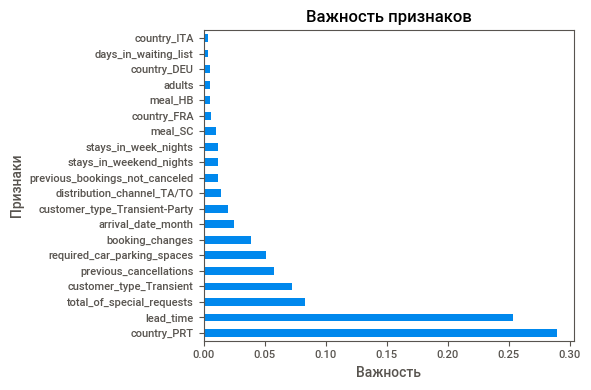

In [82]:
pd.Series(model.feature_importances_, features_train.columns).nlargest(20).plot(kind='barh')
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

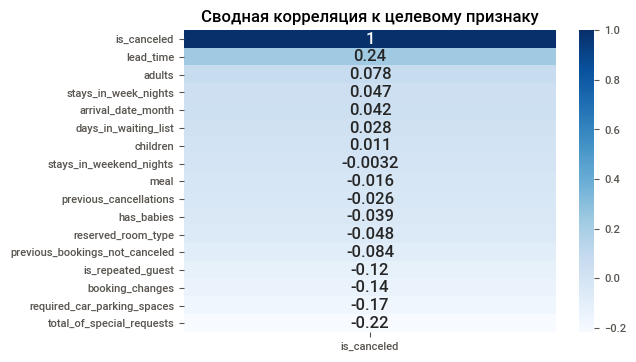

In [83]:
hotel_concat = pd.concat([df_test, df_test])
sns.heatmap(hotel_concat.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
                annot = True, annot_kws = {"size":12}, cmap='Blues')
plt.title('Сводная корреляция к целевому признаку')
plt.show()

In [84]:
df_test1.query('is_canceled == 1 and predictions == 1').describe(include = 'all')

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season,predictions
count,8251.0,8251.000000,8251.000000,8251.000000,8251.000000,8251.000000,8251.000000,8251.000000,8251,8251,8251,8251.000000,8251.000000,8251.000000,8251,8251.000000,8251.000000,8251,8251.0,8251.000000,8251,8251.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,39,3,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,TA/TO,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,spring,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6766,5219,7738,NaN,NaN,NaN,6554,NaN,NaN,7601,NaN,NaN,4105,NaN
mean,1.0,128.560781,4.557993,0.843777,2.382257,1.889710,0.075264,0.001454,NaN,NaN,NaN,0.001818,0.002666,0.009090,NaN,0.062901,0.409526,NaN,0.0,0.093201,NaN,1.0
std,0.0,82.014439,1.927693,0.858161,1.278084,0.454957,0.332167,0.038111,NaN,NaN,NaN,0.042601,0.066004,0.307545,NaN,0.341539,4.535746,NaN,0.0,0.346643,NaN,0.0
min,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,NaN,1.0
25%,1.0,61.000000,3.000000,0.000000,1.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,NaN,1.0
50%,1.0,120.000000,5.000000,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,NaN,1.0
75%,1.0,175.000000,6.000000,2.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,NaN,1.0


In [85]:
import pprint
for col in obj_features:
    print(col)
    print(df_test1.query('is_canceled == 1 and predictions == 1')[col].value_counts(normalize = True), '\n')

meal
BB    0.820022
SC    0.122046
HB    0.056236
FB    0.001697
Name: meal, dtype: float64 

country
PRT      0.632529
GBR      0.056963
ESP      0.040116
FRA      0.037935
BRA      0.034905
ITA      0.032602
IRL      0.017574
CHN      0.014544
BEL      0.013574
other    0.012968
USA      0.011877
DEU      0.011150
CHE      0.010665
NLD      0.009453
NOR      0.007757
AUT      0.007151
CN       0.004969
DNK      0.004484
SWE      0.004363
RUS      0.003636
AUS      0.003394
POL      0.003394
ISR      0.003151
ROU      0.003030
LUX      0.002909
KOR      0.002303
FIN      0.001576
TUR      0.001454
MAR      0.001333
HUN      0.001333
ARG      0.001091
AGO      0.000970
CZE      0.000970
GRC      0.000848
ZAF      0.000727
IND      0.000727
HRV      0.000727
JPN      0.000606
MEX      0.000242
Name: country, dtype: float64 

distribution_channel
TA/TO        0.937826
Corporate    0.034784
Direct       0.027391
Name: distribution_channel, dtype: float64 

reserved_room_type
A    0.794328

В описании "ненадежного" клиента можно выделить следующие признаки: Бронирует примерно за большой срок (4 месяца) до прибытия в отель.

остается примерно на 1 ночь в выходные и на две ночи в рабочие дни.

Количество взрослых постояльцев в среднем равно 2, без детей и младенцев.

Он не был раньше в этом отеле, поэтому значения признаков отмененных предыдущих заказов и неотмененных заказов стремиться к нулю.

Он совсем не вносит изменений в свой заказ.

В среднем ожидает заказа 0 или 1 день.

Ему не нужно порковочное место.

Не делает специальные отметки.

Обычно бронирует номер на май или апрель.

Чаще всего у него включен завтрак в заказе номера.

Обычно этот клиент из Португалии.

Он заказывает самый дорогой тип комнат - А.

Его тип не связан с договором или с групповым заездом.

### Шаг 6. Напишите общий вывод

В данной работе в нашем распоряжении были данные о пользователях сети отелей. Имеются данные о количестве постояльцев, их гражданства, типе заказчика, количестве ночей, а также об отменах бронирования. Для привлечения клиентов сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Основная задача данного проекта заключалась в разработке системы, которая может предсказать, что клиент откажется от брони, что приведет к сокращению убытков компании.

Был проведен первичный анализ данных. Определен целевой показатель "отмена заказа" и рассмотрено распределение по всем факторам. Проведена преобработка данных. Установлено, что в данных отсутствуют пропуски и дубликаты. Устранены неявные признаки, связанные с пробелами в названиях. Изменен тип данных для категориальных значений. Из данных удалены лишние столбцы, не влияющие на формирование модели. Удалены явные выбросы и нестыковки в данных, такие как бронирование детьми без взрослых, количество детей 10 и т.д.

Для проведения исследовательского анализа получен отчет методом sweetwiz. Определены прямые и косвенные корреляции между признаками. По результатам исследовательского анализа установлено: Отменяется 37-39 % брони. Мы наблюдаем некий дисбаланс целевого признака, который нужно в дальнейшем уравнять, хотя он не является критичным. На значение целевого показателя по отменам бронирования наибольшее влияние оказывают время от бронирования до заселения и предыдущие отмены. Дополнительно определено, что на целевой показатель также влияют страна клиента и количество специальных отметок. Положительно на ситуацию с отменой брони влияют такие показатели как количество специальных отметок, необходимость места для автомобиля, количество изменений параметров заказа, регулярность посещения гостем отеля и количество подтверждённых заказов у клиента. Пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году. Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.

Была проведена оценка прибыли отеля без внедрения депозитов, которая показала, что для окупаемости прибыль с внедренияим депозитов должна быть >= 35.0869 млн.руб. Перед формированием моделей предсказания отказа от бронирования было проведено масштабирование признаков и увеличение выборки. В качестве целевой метрики для выбора подходящей модели был выбран показатель f1. Проведено обучение моделей случайного леса, дерева решений и логистической регрессии. Наилучшей моделью была выбрана модель дерева решений, с помощью которой были сделаны предсказания оттока клиентов. С помощью модели предсказания и внедрения сбора депозитов с потенциальных "отказников" удалось добиться увеличения прибыли на 32 млн. рублей.

Были определены основные признаки "ненадежного" клиента, среди которых можно выделить:

Бронирует примерно за большой срок (4 месяца) до прибытия в отель.

остается примерно на 1 ночь в выходные и на две ночи в рабочие дни.

Количество взрослых постояльцев в среднем равно 2, без детей и младенцев.

Он не был раньше в этом отеле, поэтому значения признаков отмененных предыдущих заказов и неотмененных заказов стремиться к нулю.

Он совсем не вносит изменений в свой заказ.

В среднем ожидает заказа 0 или 1 день.

Ему не нужно порковочное место.

Не делает специальные отметки.

Обычно бронирует номер на май или апрель.

Чаще всего у него включен завтрак в заказе номера.

Обычно этот клиент из Португалии.

Он заказывает самый дорогой тип комнат - А.

Его тип не связан с договором или с групповым заездом.

Внедрение модели прогнозирования отказов клиентов от броинрования и выставления депозитов для данного типа клиентов позволит увеличить прибыль компании на сумму более 30 млн. рублей.